# Packages loading

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib as mpl
import seaborn as sns
import warnings
from scipy import interpolate
from astropy import coordinates
from astropy.coordinates import Galactic
import astropy.units as u
import mass_photometry_tools as massPhoto
from astropy.coordinates import LSR
from astropy.coordinates import SkyCoord
import pickle

sns.set_context("talk")
mpl.style.use("seaborn")
sns.set_context("paper",font_scale=1.5)
sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

# Data reading

In [2]:
finalStatsForNymgs = pd.read_csv('statsForSyntheticNymgs.csv')    

# Functions

## The nMaxFinder function:
This function receives a dataframe data with two columns, nMembers and nClusters and a fraction between 0 and 1 confidenceLevel. The function returns the smallest integer for which confidenceLevel percent of the total integral under the curve nMembers(nClusters) is contained on the left of of it.

In [3]:
def nMaxFinder(data,confidenceLevel,NclusterMin):
    if data.shape[0] > 0:
        nTotal  = data.nClusters.sum()
        for i in np.arange(0,data.shape[0],1):
            nMembersSum  = data.iloc[0:i+1].nClusters.sum()
            realLevel    = nMembersSum/nTotal
            if realLevel >= confidenceLevel:
                break
        Nmax = data.nMembers[i]
        if Nmax < NclusterMin:
            Nmax = NclusterMin
    else:
        Nmax = NclusterMin
    return Nmax

In [4]:
isochroneAges = pd.DataFrame({'age':np.arange(10e6,110e6,10e6)})
ages          = []
for i in np.arange(0,finalStatsForNymgs.shape[0],1):
    ages += [isochroneAges[np.abs(isochroneAges.age-finalStatsForNymgs.age.iloc[i]*1e6) == np.min(np.abs(isochroneAges.age-finalStatsForNymgs.age.iloc[i]*1e6))].iloc[0][0]]

ages = np.unique(ages)

# The fieldCharacterizer function

The following function characterize the fields results by computing the minimum number of members detected clusters must have (nvrClusterFinal) in order to be significant at a given confidence level and for a given parameter combination. nlimit put an upper limit on the number of sources from a cluster from the field results.

In [5]:
def fieldCharacterizer(age,Nlimit,confidence,nvrClusterInfo,NclusterMin):
    deltaNmin = list(nvrClusterInfo.keys())
    deltaVeps = list(nvrClusterInfo[deltaNmin[0]].keys())
    deltaReps = list(nvrClusterInfo[deltaNmin[0]][deltaVeps[0]].keys())

    nvrNmax         = {}
    nvrClusterFinal = {}
    for nind in np.arange(0,len(deltaNmin),1):
        Nmin    = deltaNmin[nind]
        vrNmax  = {}
        vrClusterFinal = {}
        for vind in np.arange(0,len(deltaVeps),1):
            veps   = deltaVeps[vind]
            rNmax  = {}
            rClusterFinal = {}
            for rind in np.arange(0,len(deltaReps),1):
                reps  = deltaReps[rind]
                Nmax  = int(nMaxFinder(nvrClusterInfo[Nmin][veps][reps],confidence,NclusterMin))
                if nvrClusterInfo[Nmin][veps][reps].shape[0] > 0:
                    Nlast = nvrClusterInfo[Nmin][veps][reps].reset_index(drop=True).iloc[len(nvrClusterInfo[Nmin][veps][reps])-1].nMembers
                else:
                    Nlast = 0
                if ((Nmax <= Nlimit) & (Nlast <= Nlimit)):
                    rClusterFinal.update({int(round(reps,1)):Nmax})
                    rNmax.update({int(reps):Nmax})
                else:
                    rNmax.update({int(reps):-float('inf')})
            vrNmax.update({float(veps):rNmax})
            if len(rClusterFinal) > 0:
                vrClusterFinal.update({float(round(veps,1)):rClusterFinal})
        nvrNmax.update({int(Nmin):vrNmax})
        if len(vrClusterFinal) > 0:
            nvrClusterFinal.update({int(round(Nmin,1)):vrClusterFinal})
    return nvrClusterFinal,nvrNmax

# $6\mathcal{D}$ synthetic field characterization

In [6]:
allnvrClusterFinal6D = {}
allnvrNmax           = {}
NclusterMin          = 5
confidence           = 0.9
nlimit               = 300
sampleClass          = 'RVs'

for ageInd in np.arange(0,len(ages),1):
    age             = ages[ageInd]
    nvrClusterInfo  = pd.read_pickle(f'dataframes_output/Ndmethod/field_characterized_{sampleClass}_{age}.pickle')
    
    nvrClusterFinal,nvrNmax = fieldCharacterizer(age,nlimit,confidence,nvrClusterInfo,NclusterMin)
    
    allnvrClusterFinal6D.update({age:nvrClusterFinal})
    allnvrNmax.update({age:nvrNmax})
    
    with open(f'dataframes_output/Ndmethod/nvrClusterFinal_{sampleClass}_{age}.pickle', 'wb') as handle:
        pickle.dump(nvrClusterFinal, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    print(age)

20000000.0
30000000.0
40000000.0
60000000.0


# $5\mathcal{D}$ synthetic field characterization

In [7]:
allnvrClusterFinal5D = {}
allnvrNmax           = {}
NclusterMin          = 10
confidence           = 0.99
nlimit               = 300
sampleClass          = '5D'

for ageInd in np.arange(0,len(ages),1):
    age                     = ages[ageInd]
    nvrClusterInfo          = pd.read_pickle(f'dataframes_output/Ndmethod/field_characterized_{sampleClass}_{age}.pickle')
    
    nvrClusterFinal,nvrNmax = fieldCharacterizer(age,nlimit,confidence,nvrClusterInfo,NclusterMin)
    
    allnvrClusterFinal5D.update({age:nvrClusterFinal})
    allnvrNmax.update({age:nvrNmax})
    
    with open(f'dataframes_output/Ndmethod/nvrClusterFinal_{sampleClass}_{age}.pickle', 'wb') as handle:
        pickle.dump(nvrClusterFinal, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    print(age)

20000000.0
30000000.0
40000000.0
60000000.0


# The parameterCoordinatesFinder

This function find the coordinates combinations that defines the ensemble of relevant combinations based on the nvrClusterFinal results

In [8]:
def parameterCoordinatesFinder(nvrClusterFinal):
    finalDeltaNmin       = list(nvrClusterFinal.keys())
    nvrClusterFinalCoord = pd.DataFrame(columns = ['Nmin','veps','reps'])

    for nind in np.arange(0,len(finalDeltaNmin),1):
        Nmin           = finalDeltaNmin[nind]
        finalDeltaVeps = list(nvrClusterFinal[Nmin].keys())
        for vind in np.arange(0,len(finalDeltaVeps),1):
            veps           = finalDeltaVeps[vind]
            finalDeltaReps = list(nvrClusterFinal[Nmin][veps].keys())
            for rind in np.arange(0,len(finalDeltaReps),1):
                reps                 = finalDeltaReps[rind]
                nvrClusterFinalCoord = pd.concat([nvrClusterFinalCoord,pd.DataFrame({'Nmin':[Nmin],'veps':[veps],'reps':[reps]})],
                                                axis=0).reset_index(drop=True)
    return nvrClusterFinalCoord

# $6\mathcal{D}$ synthetic parameters ensemble

In [9]:
allnvrClusterFinalCoord6D = {}
sampleClass               = 'RVs'

for ageInd in np.arange(0,len(ages),1):
    age                     = ages[ageInd]
    nvrClusterFinal         = allnvrClusterFinal6D[age]
    
    nvrClusterFinalCoord    = parameterCoordinatesFinder(nvrClusterFinal)
    allnvrClusterFinalCoord6D.update({age:nvrClusterFinalCoord})
    
    nvrClusterFinalCoord.to_csv(f'dataframes_output/Ndmethod/nvrClusterFinalCoord_{sampleClass}_{age}.csv',index=False)
    print(age)

20000000.0
30000000.0
40000000.0
60000000.0


# $5\mathcal{D}$ synthetic parameters ensemble

In [10]:
allnvrClusterFinalCoord5D = {}
sampleClass               = '5D'

for ageInd in np.arange(0,len(ages),1):
    age                     = ages[ageInd]
    nvrClusterFinal         = allnvrClusterFinal5D[age]
    
    nvrClusterFinalCoord    = parameterCoordinatesFinder(nvrClusterFinal)
    allnvrClusterFinalCoord5D.update({age:nvrClusterFinalCoord})
    
    nvrClusterFinalCoord.to_csv(f'dataframes_output/Ndmethod/nvrClusterFinalCoord_{sampleClass}_{age}.csv',index=False)
    print(age)

20000000.0
30000000.0
40000000.0
60000000.0


In [11]:
NvNrMaps   = {'nr':{},'nv':{}}

deltaNmin = list(nvrClusterInfo.keys())
deltaVeps = list(nvrClusterInfo[deltaNmin[0]].keys())
deltaReps = list(nvrClusterInfo[deltaNmin[0]][deltaVeps[0]].keys())

colmapReps = [deltaReps[0]-(deltaReps[1]-deltaReps[0])/2]
colmapVeps = [deltaVeps[0]-(deltaVeps[1]-deltaVeps[0])/2]
colmapNmin = [deltaNmin[0]-(deltaNmin[1]-deltaNmin[0])/2]  

for rind in np.arange(0,len(deltaReps),1):
    reps       = deltaReps[rind] 
    nvmaps     = pd.DataFrame(np.zeros([len(deltaNmin),len(deltaVeps)]),index=deltaNmin,columns=deltaVeps)
    colmapReps = colmapReps + [deltaReps[rind]+(deltaReps[1]-deltaReps[0])/2]
    for vind in np.arange(0,len(deltaVeps),1):
        veps  = deltaVeps[vind]
        for nind in np.arange(0,len(deltaNmin),1):
            deltaNminFinal = list(nvrClusterFinal.keys())
            Nmin                    = deltaNmin[nind]
            nvmaps[veps].loc[Nmin]  = nvrNmax[Nmin][veps][reps]
    NvNrMaps['nv'].update({reps:nvmaps})
    
    
for vind in np.arange(0,len(deltaVeps),1):
    veps       = deltaVeps[vind] 
    nrmaps     = pd.DataFrame(np.zeros([len(deltaNmin),len(deltaReps)]),index=deltaNmin,columns=deltaReps)
    colmapVeps = colmapVeps + [deltaVeps[vind]+(deltaVeps[1]-deltaVeps[0])/2]
    for rind in np.arange(0,len(deltaReps),1):
        reps  = deltaReps[rind]
        for nind in np.arange(0,len(deltaNmin),1):
            Nmin                    = deltaNmin[nind]
            nrmaps[reps].loc[Nmin] = nvrNmax[Nmin][veps][reps]
    NvNrMaps['nr'].update({veps:nrmaps})
    

for nind in np.arange(0,len(deltaNmin),1):
    colmapNmin = colmapNmin + [deltaNmin[nind]+(deltaNmin[1]-deltaNmin[0])/2]

colmapReps, colmapNminR = np.meshgrid(colmapReps,colmapNmin)

colmapVeps, colmapNminV = np.meshgrid(colmapVeps,colmapNmin)

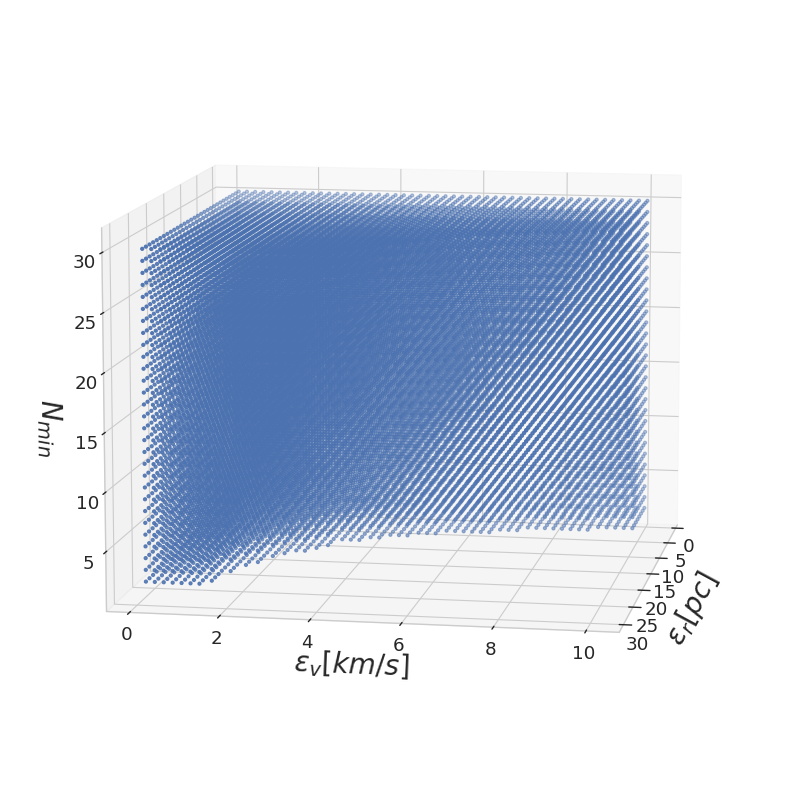

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
fig.set_figheight(10)
fig.set_figwidth(20)
ax.scatter(nvrClusterFinalCoord.reps,nvrClusterFinalCoord.veps,nvrClusterFinalCoord.Nmin,s=5)
ax.set_xlabel(r'$\varepsilon_r[pc]$',fontsize=20)
ax.set_ylabel(r'$\varepsilon_v[km/s]$',fontsize=20)
ax.set_zlabel(r'$N_{min}$',fontsize=20)
ax.tick_params(axis='both', which='major', pad=0)
ax.view_init(10,10)
plt.show()

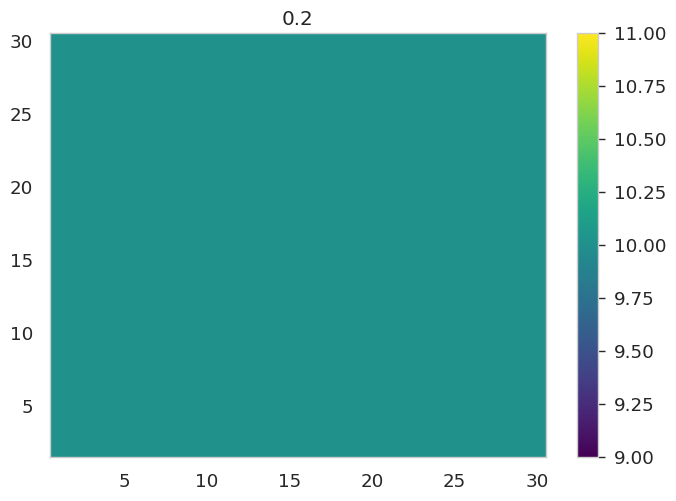

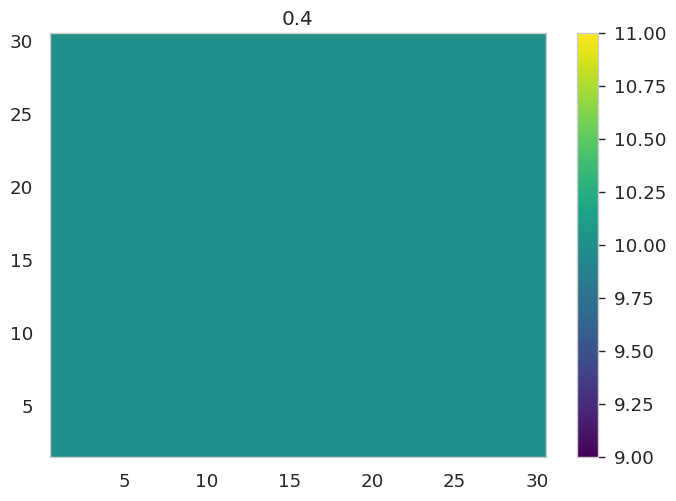

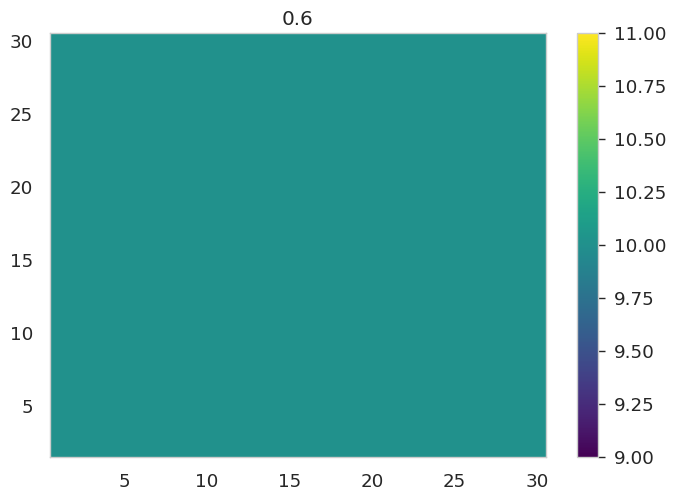

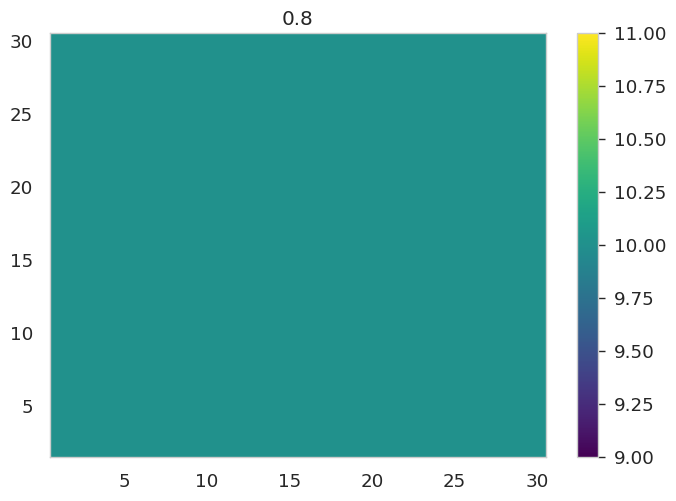

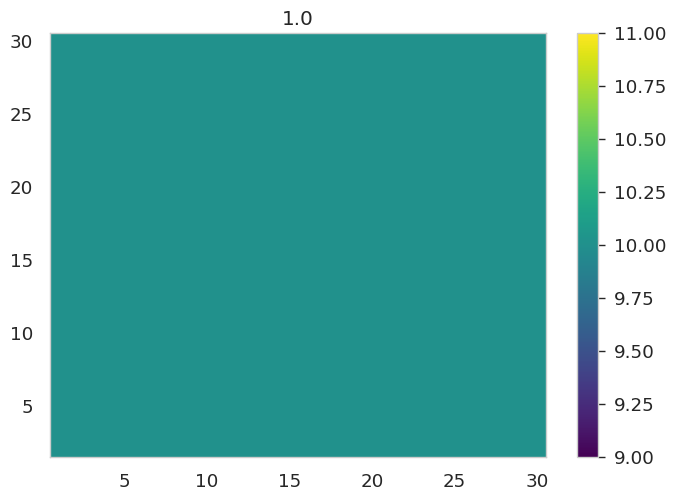

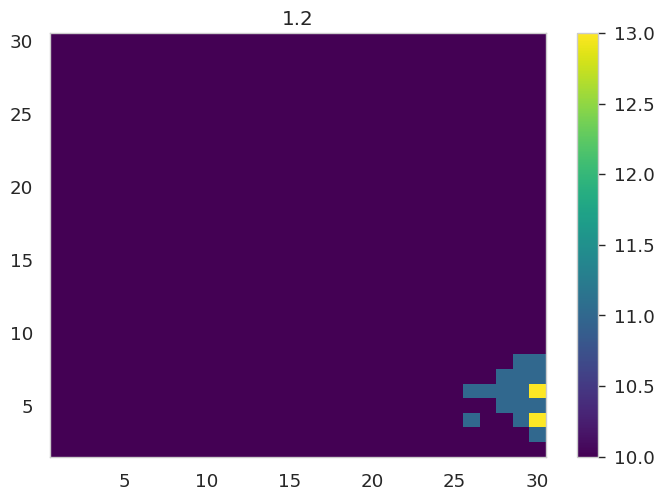

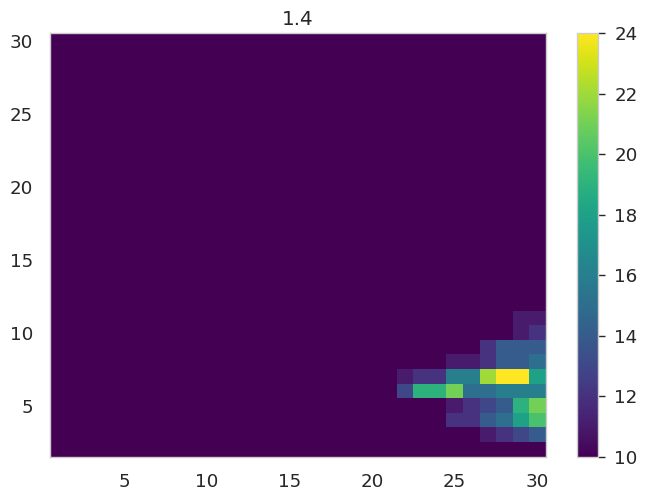

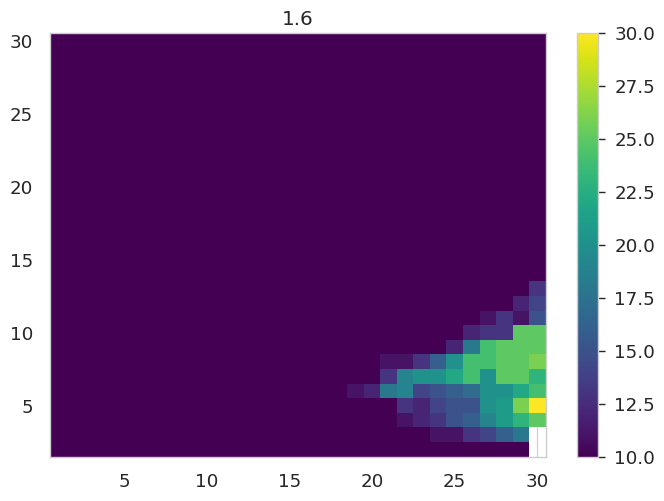

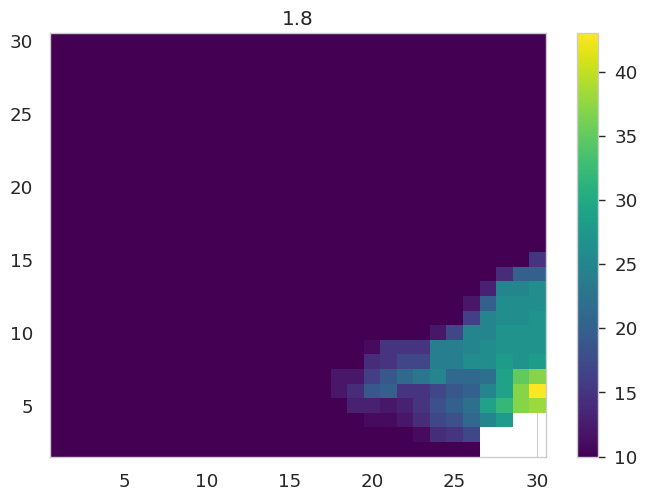

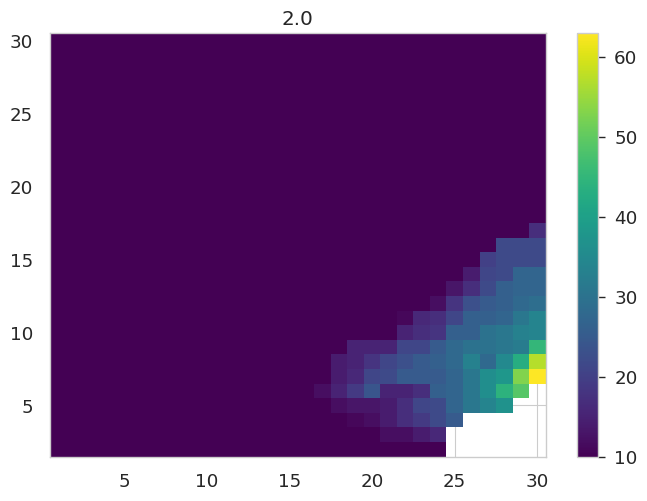

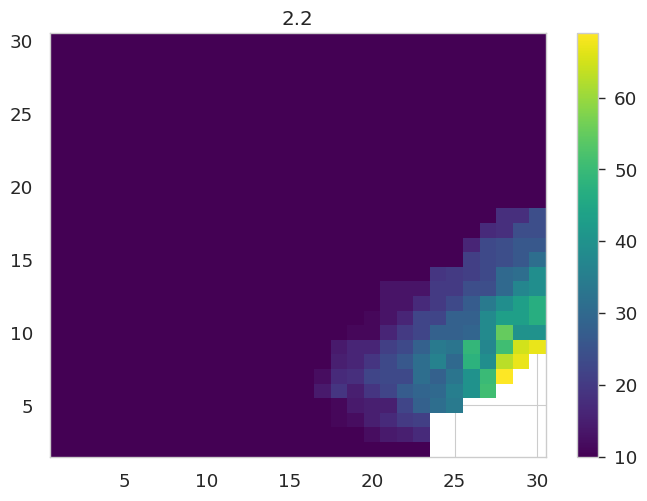

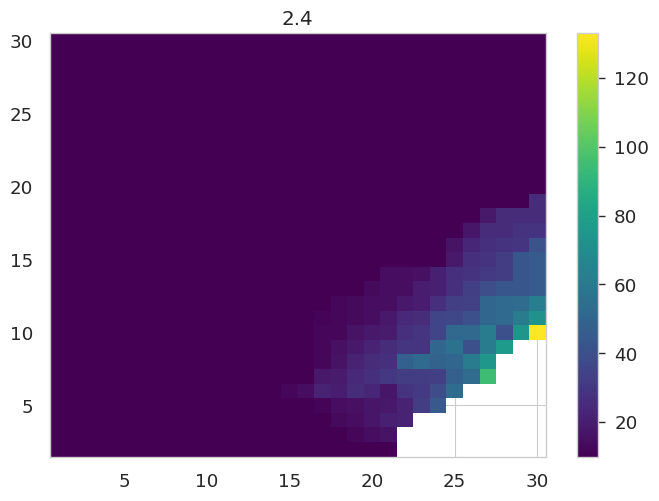

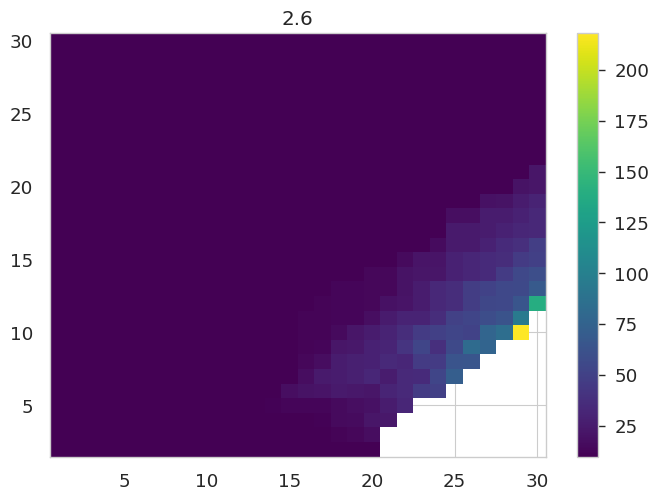

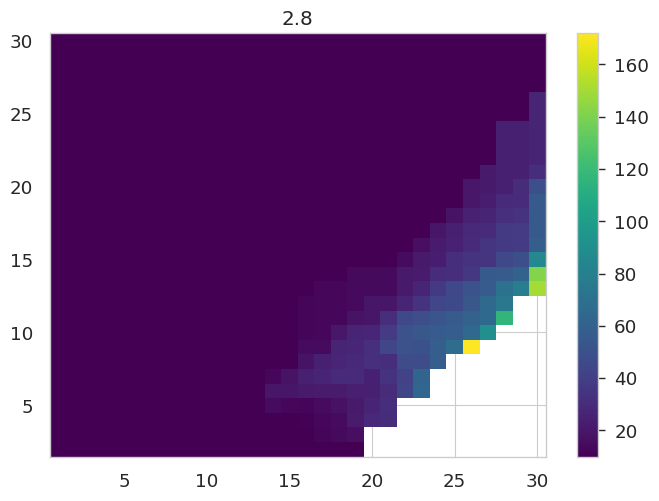

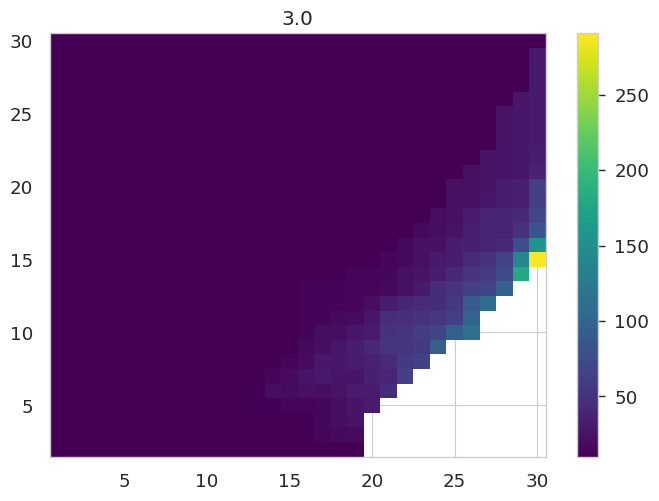

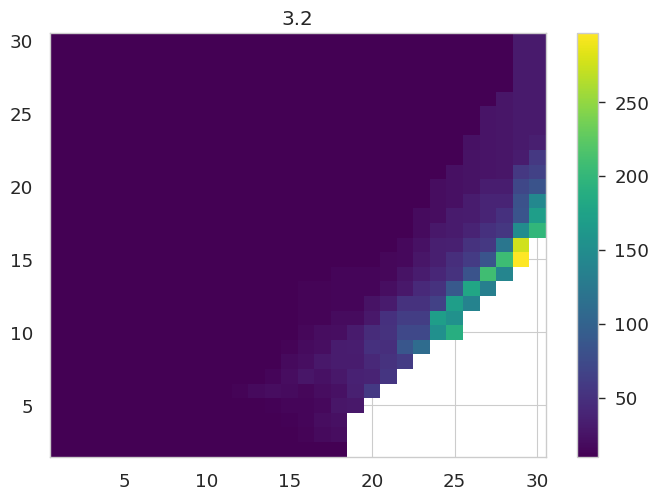

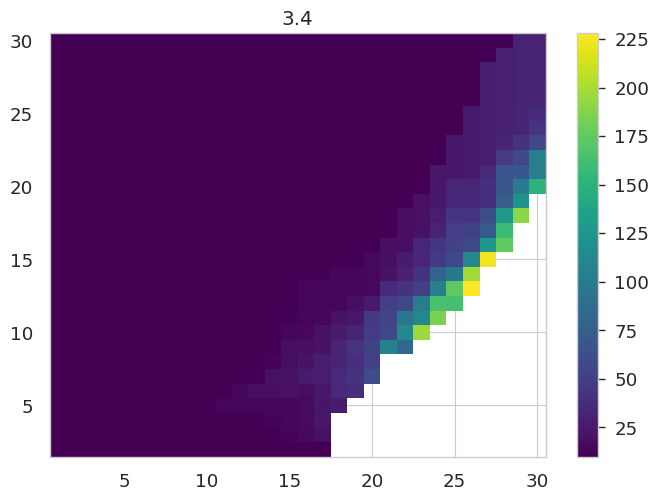

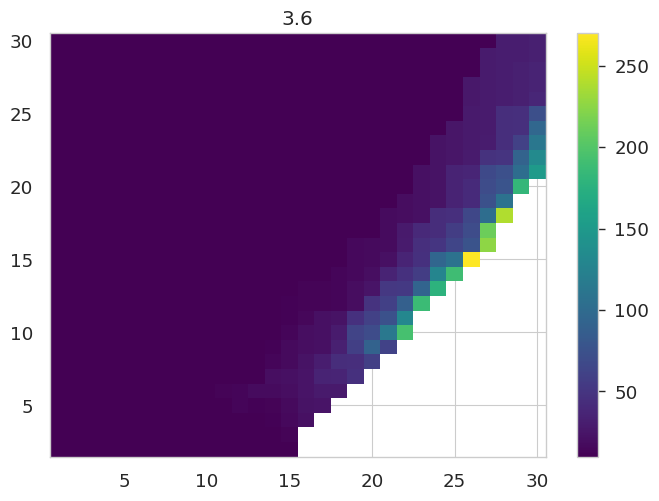

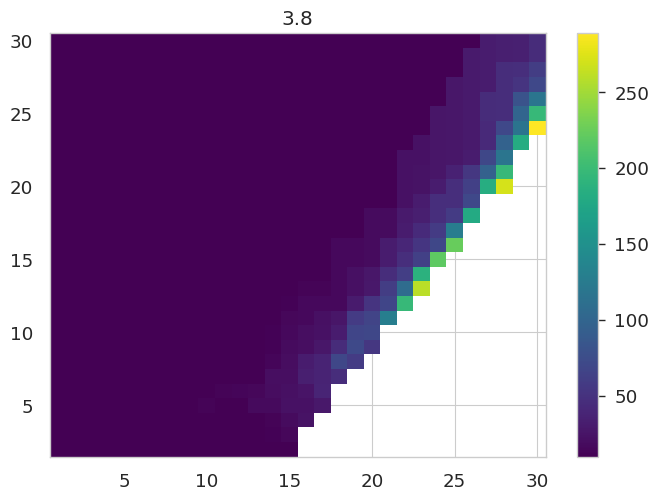

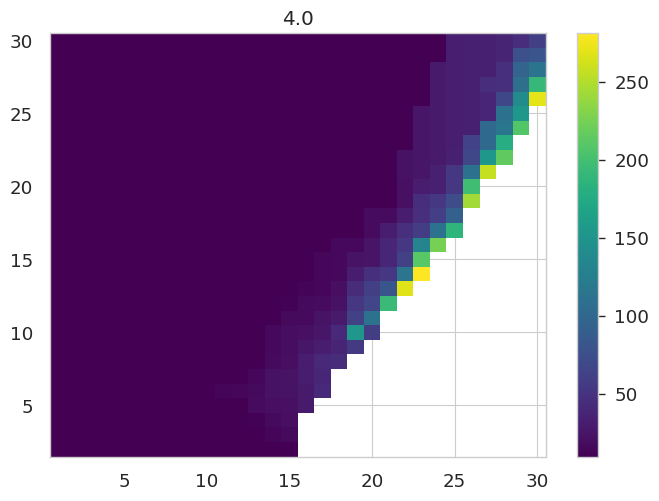

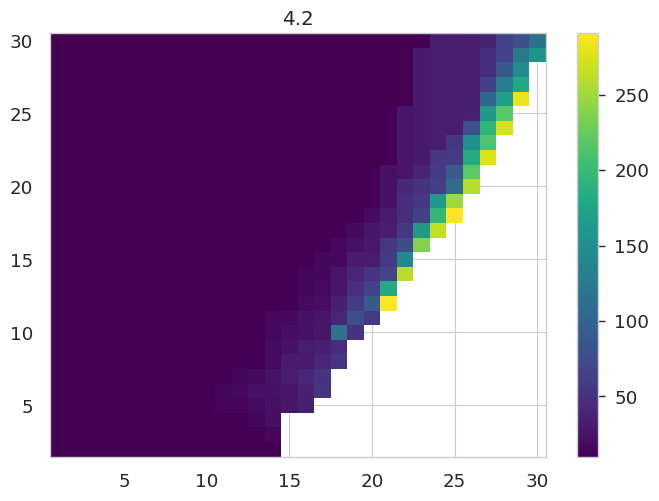

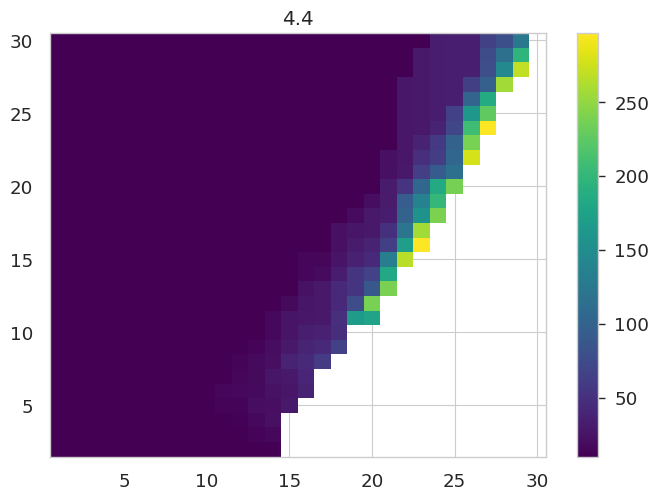

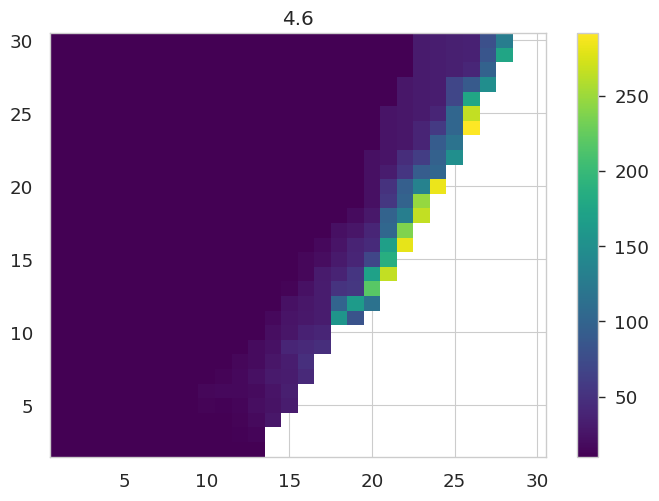

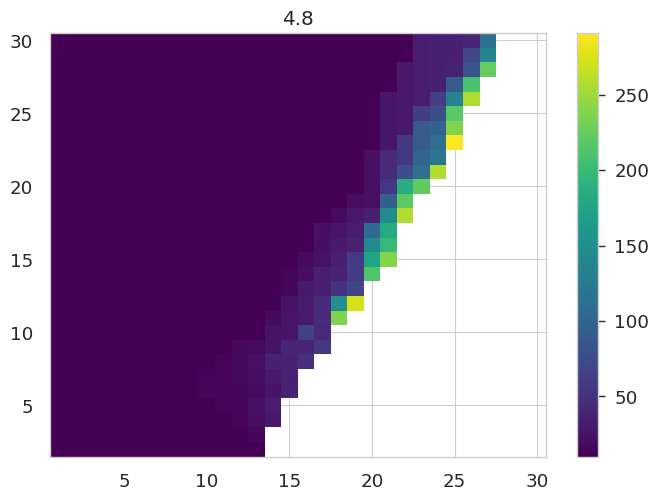

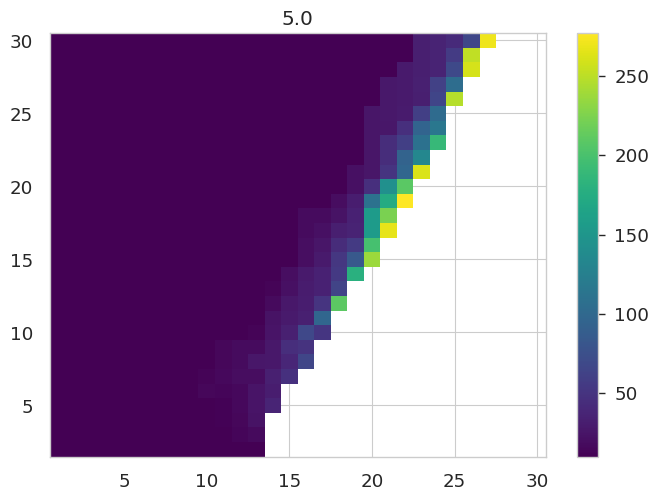

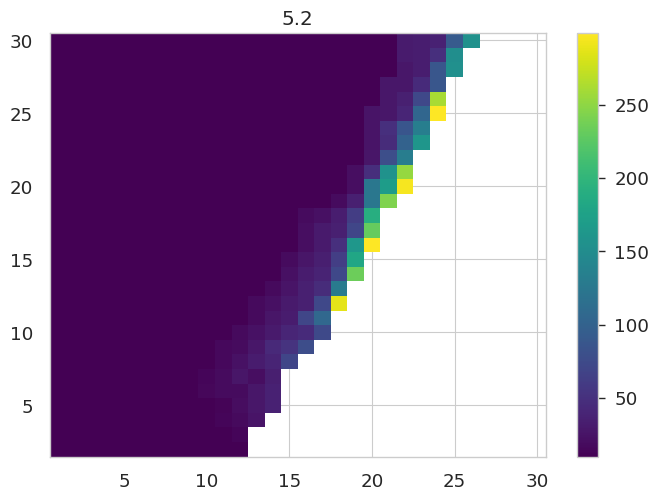

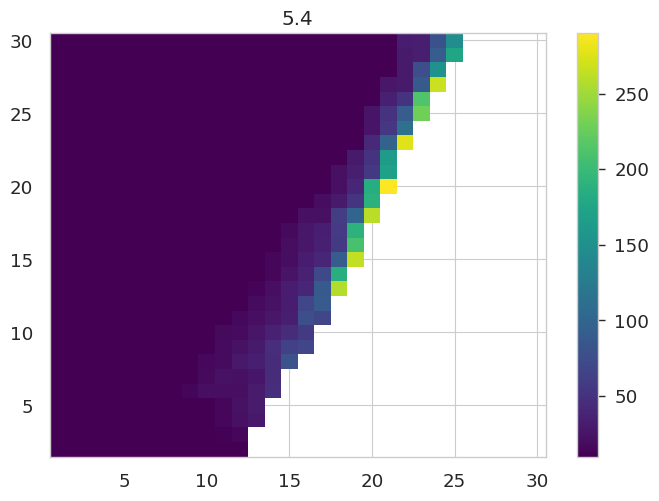

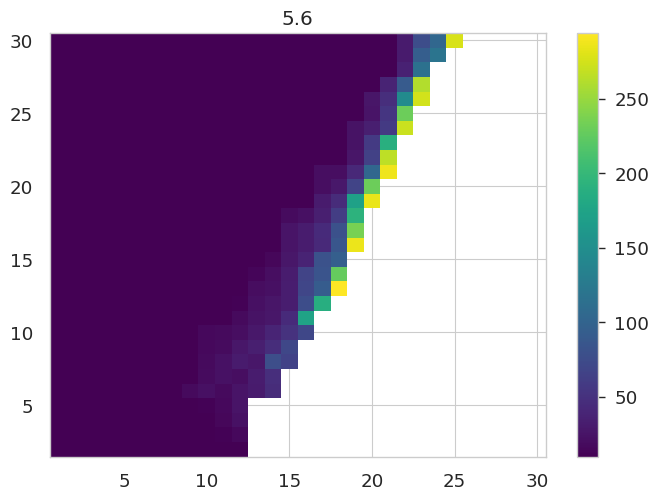

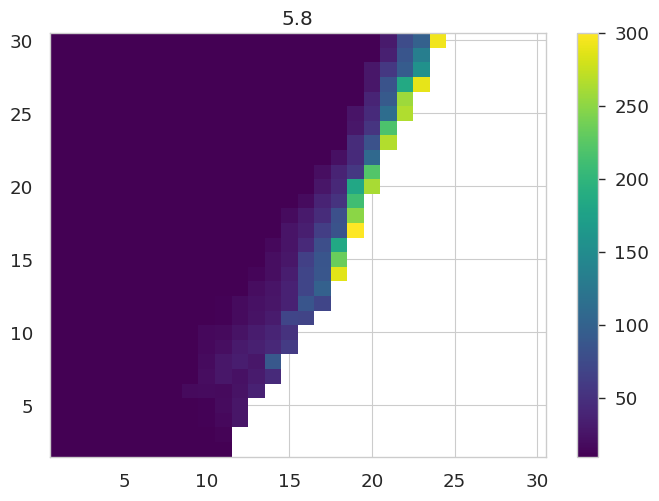

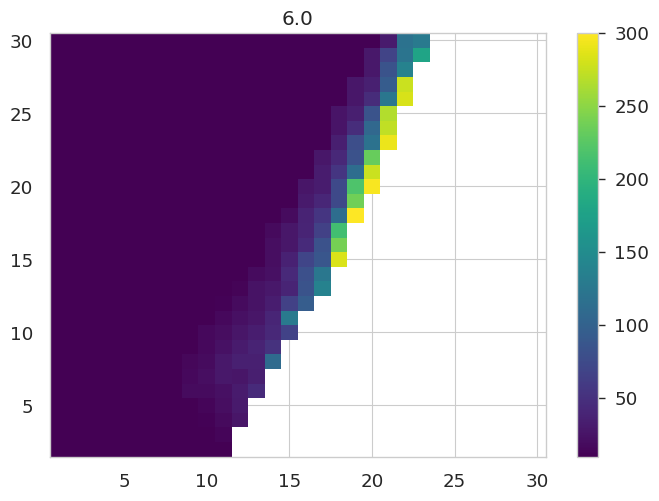

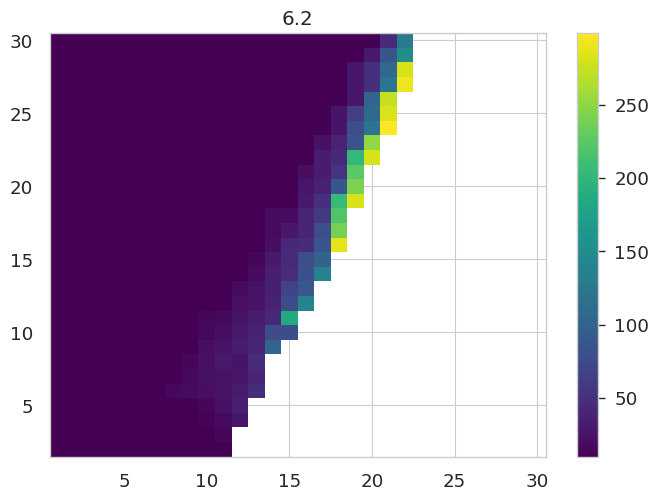

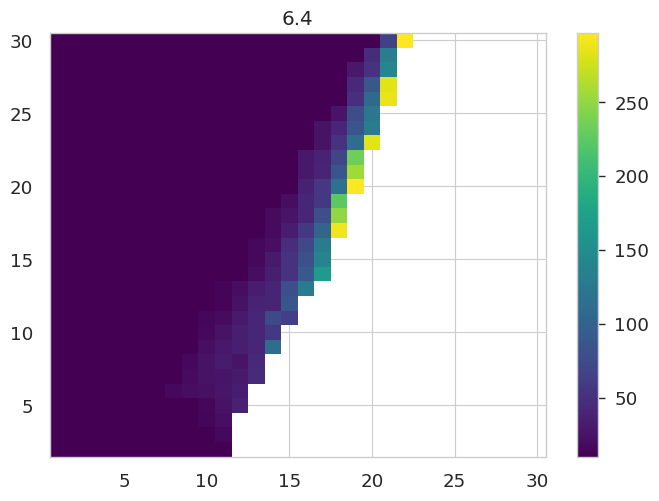

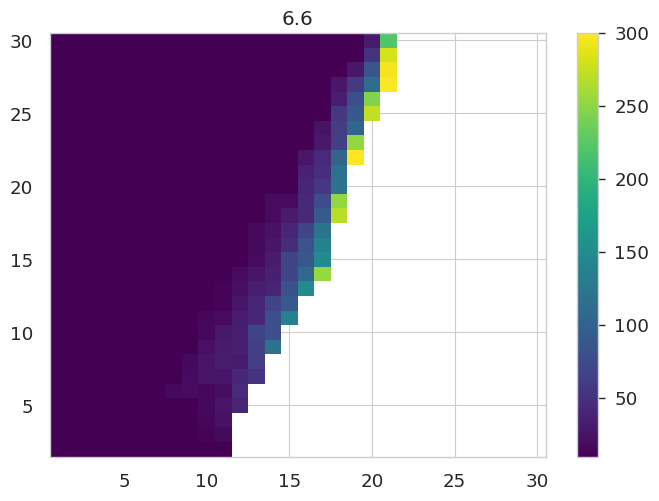

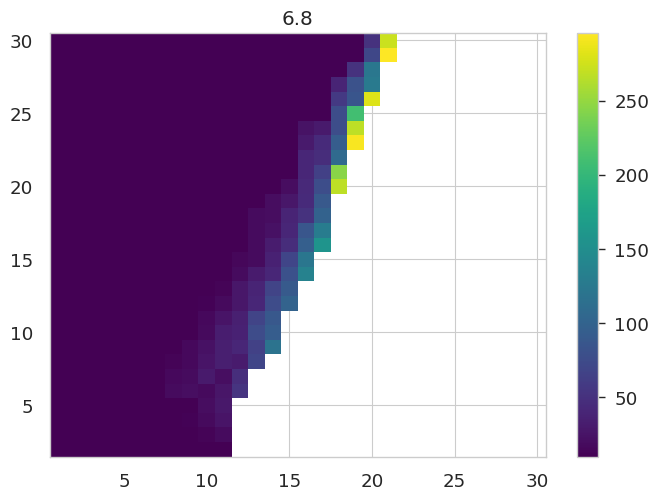

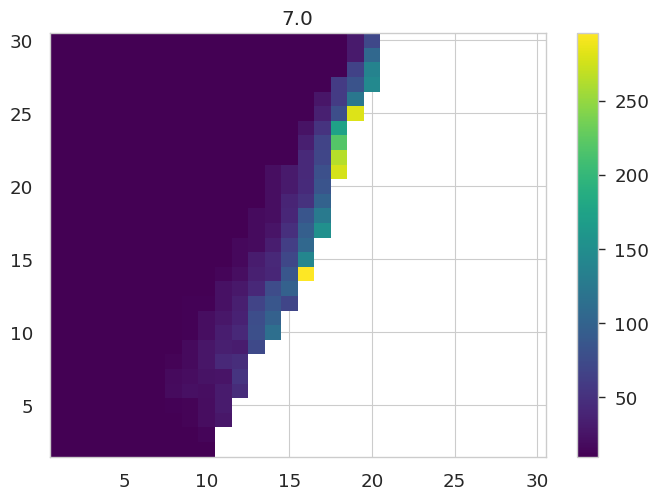

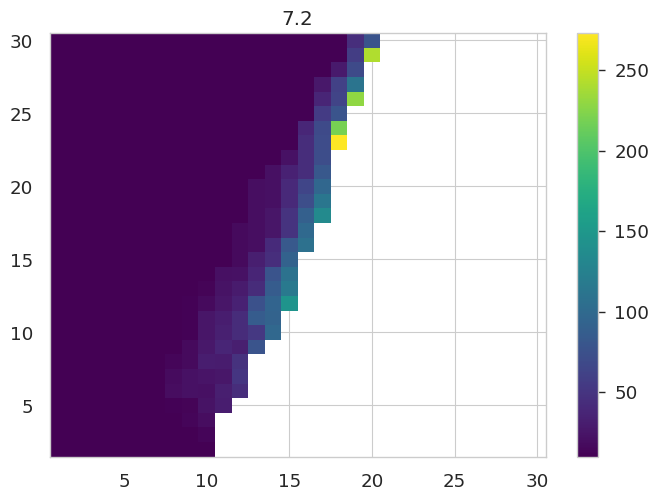

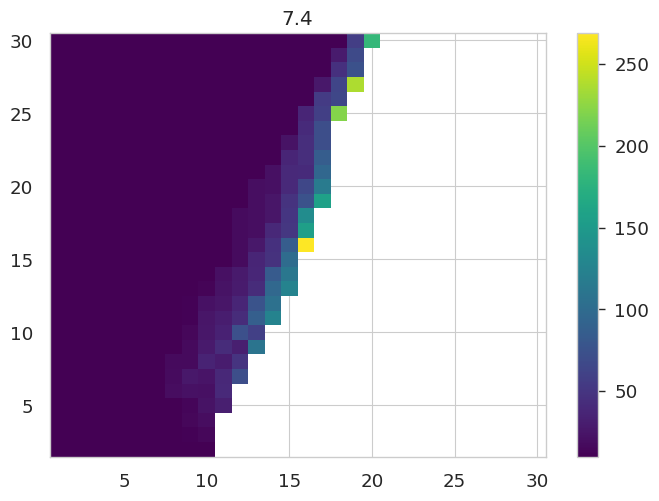

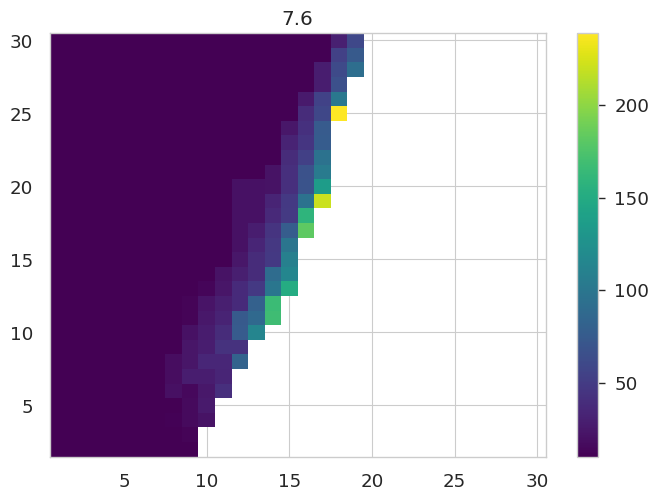

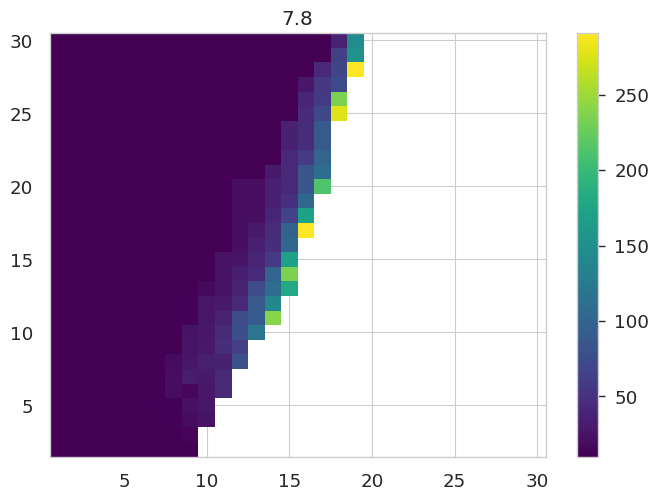

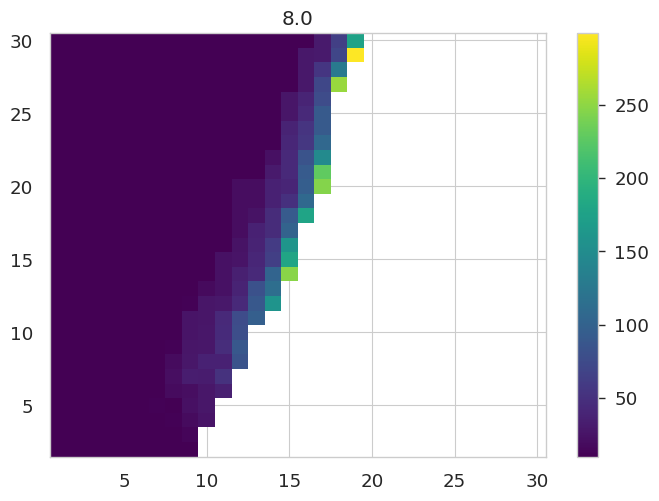

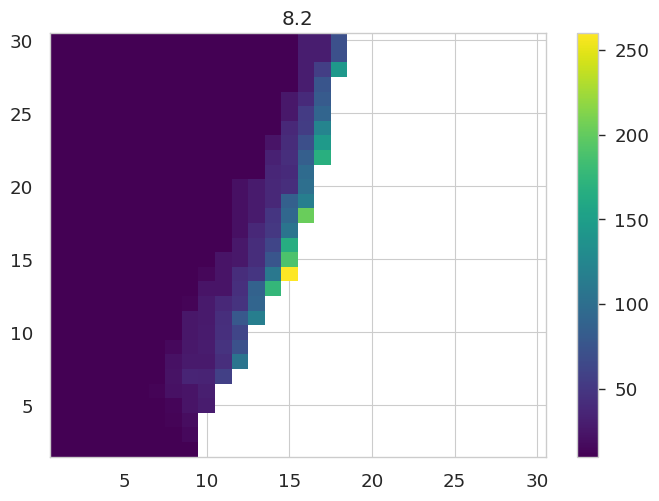

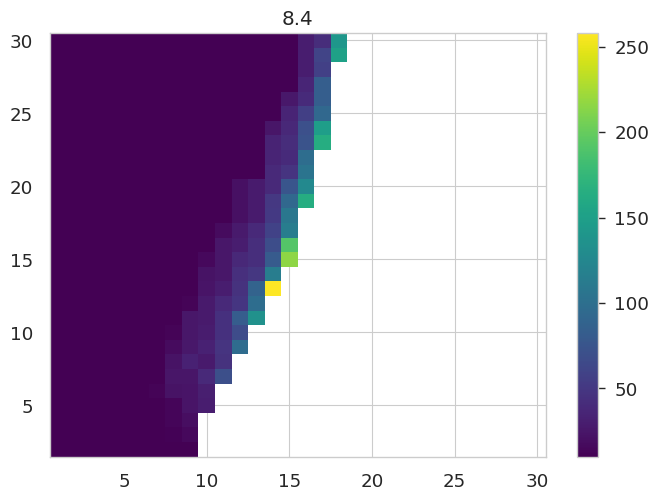

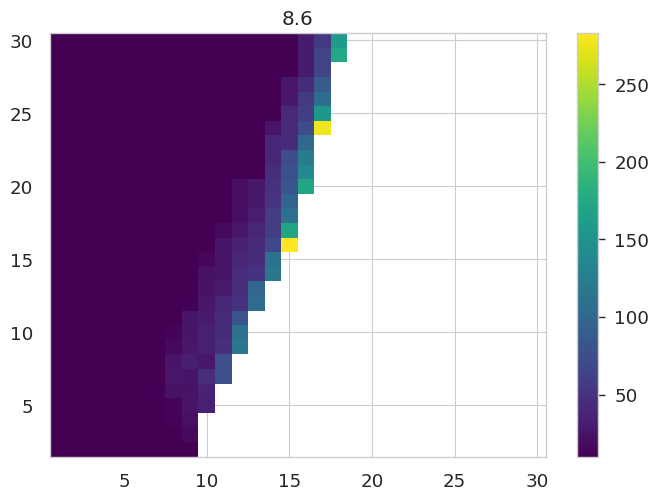

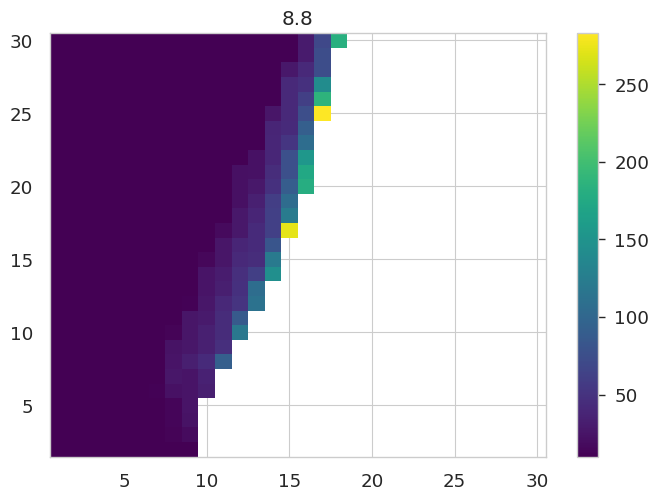

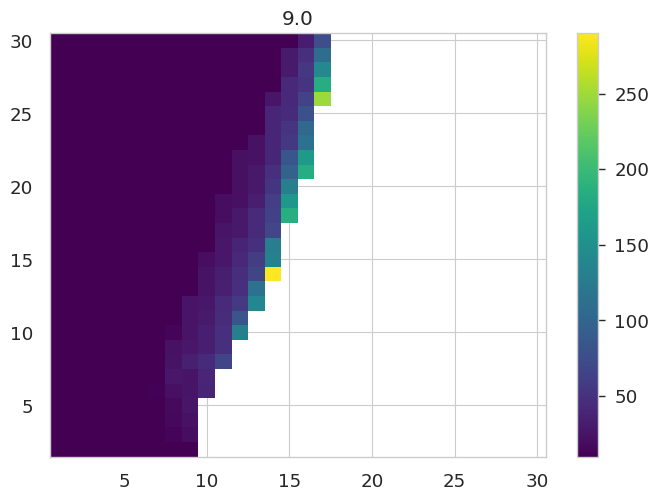

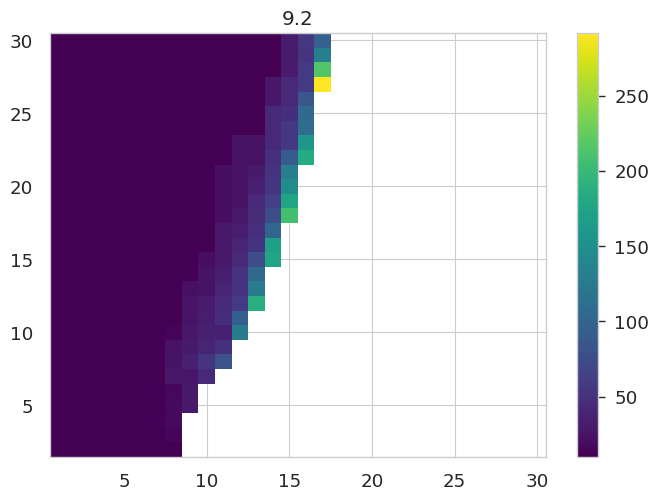

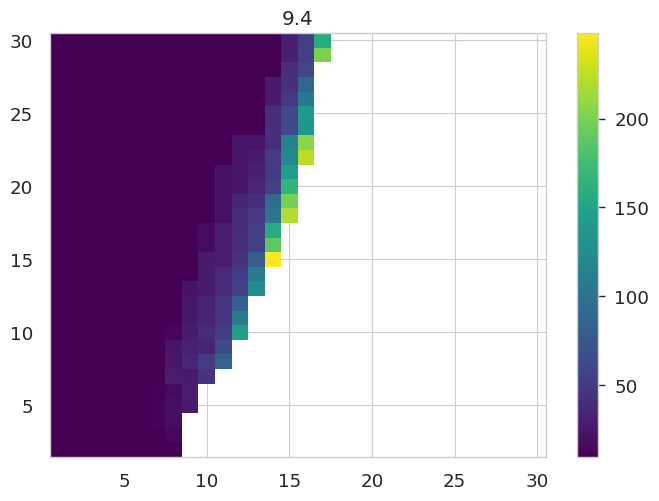

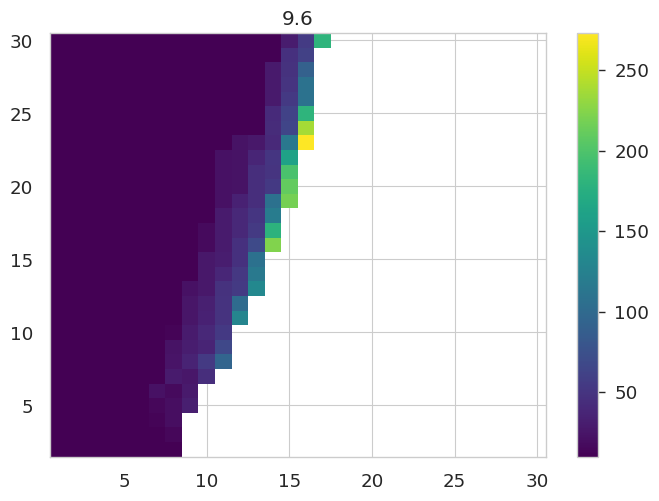

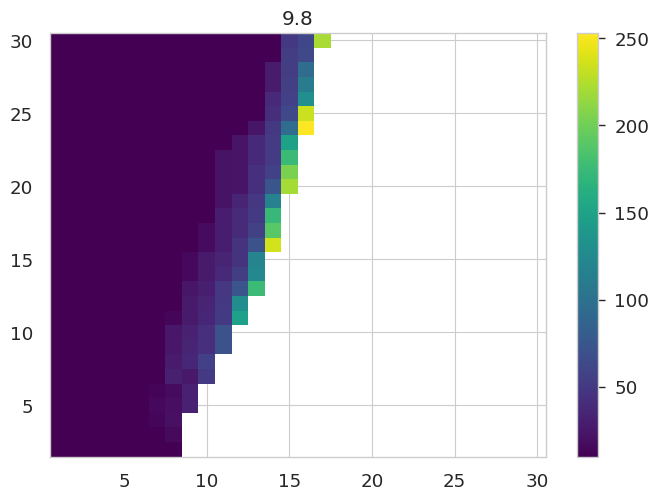

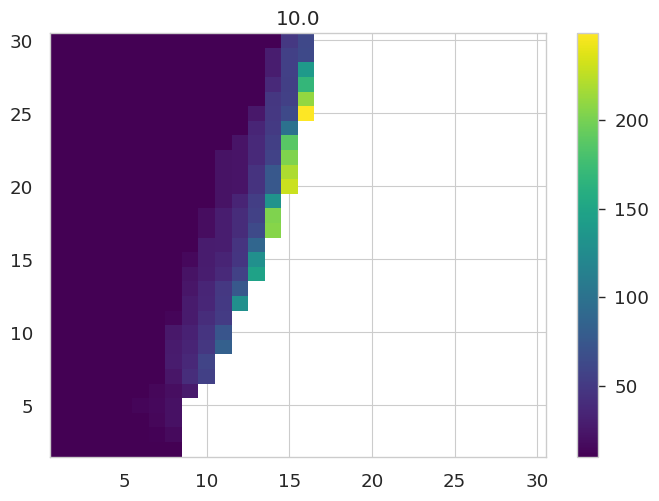

In [13]:
for vind in np.arange(0,len(deltaVeps),1):
    veps = deltaVeps[vind]
    nrmaps = NvNrMaps['nr'][veps]
    plt.pcolormesh(colmapReps,colmapNminR,nrmaps,cmap='viridis');
    plt.title(veps)
    plt.colorbar();
    plt.show();

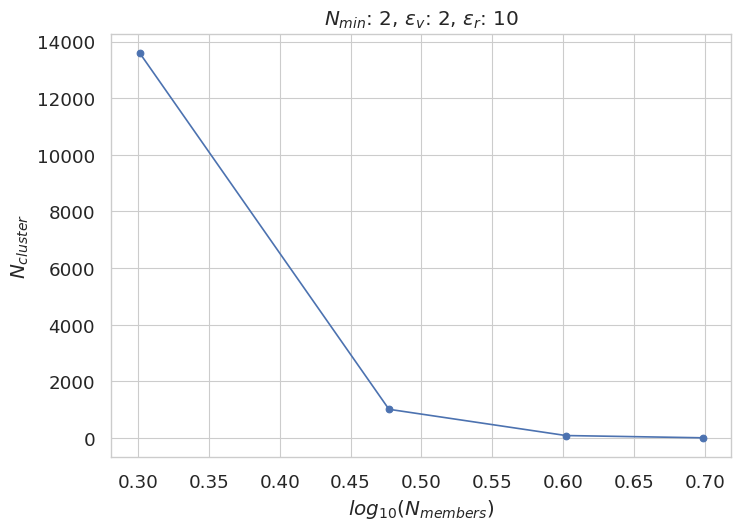

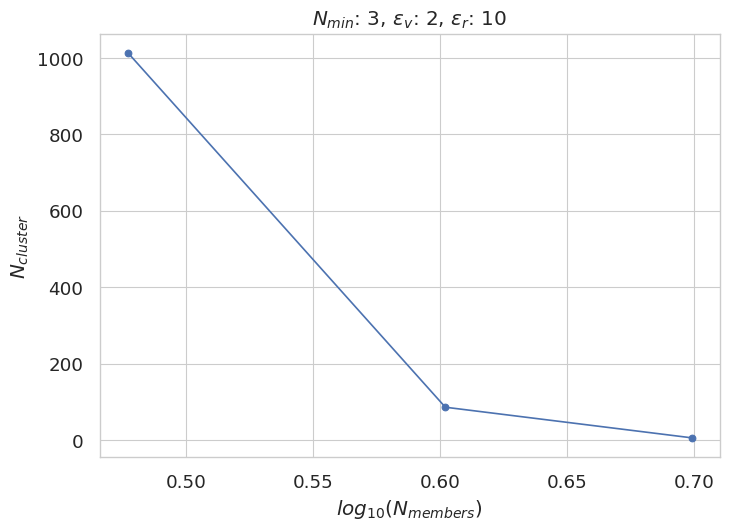

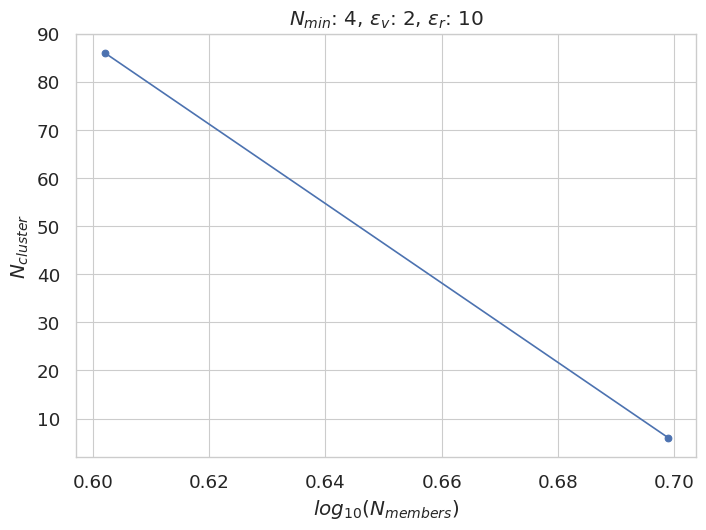

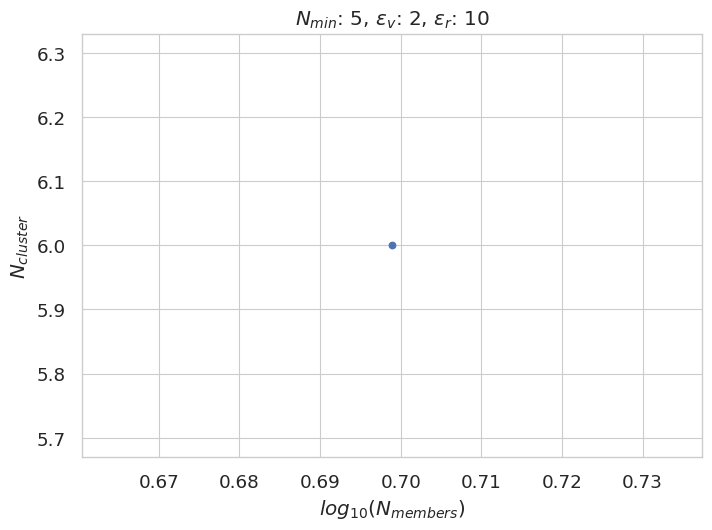

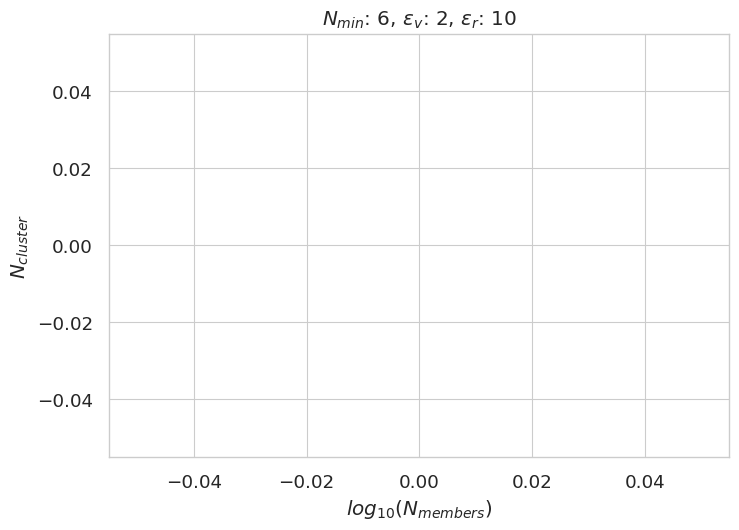

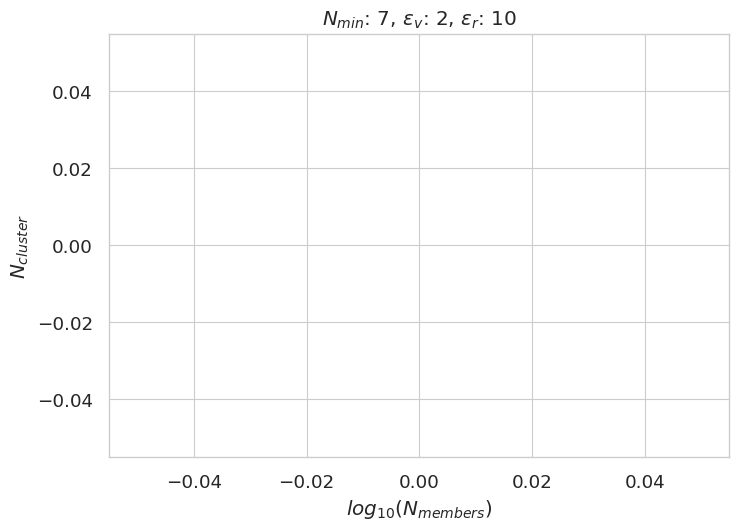

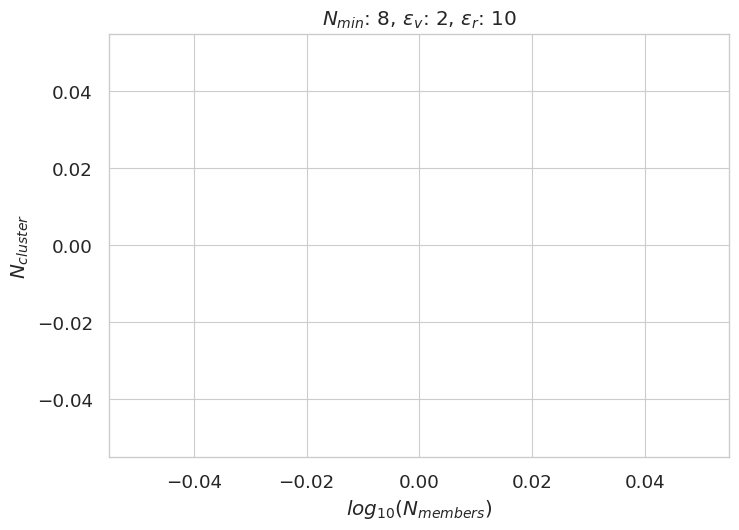

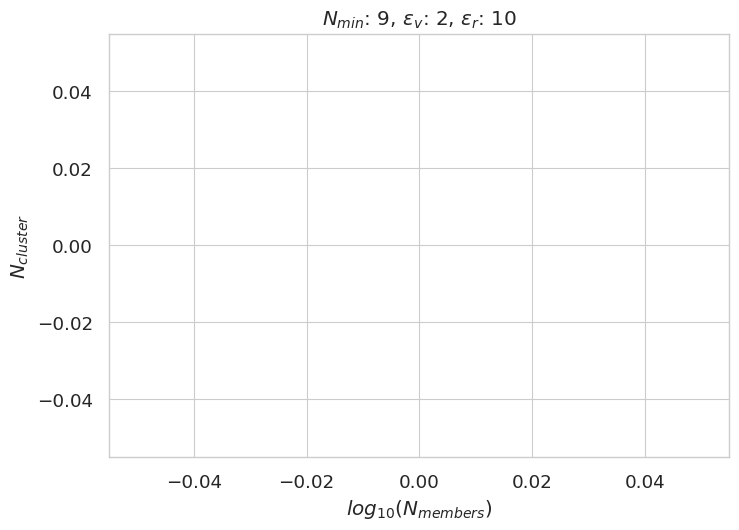

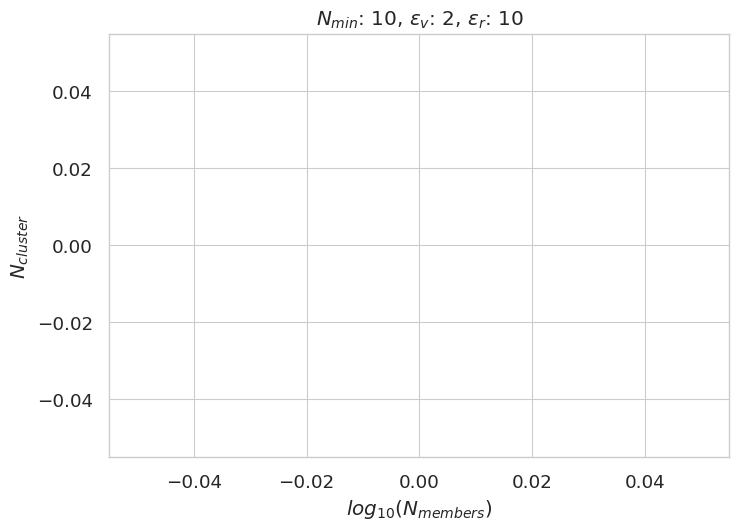

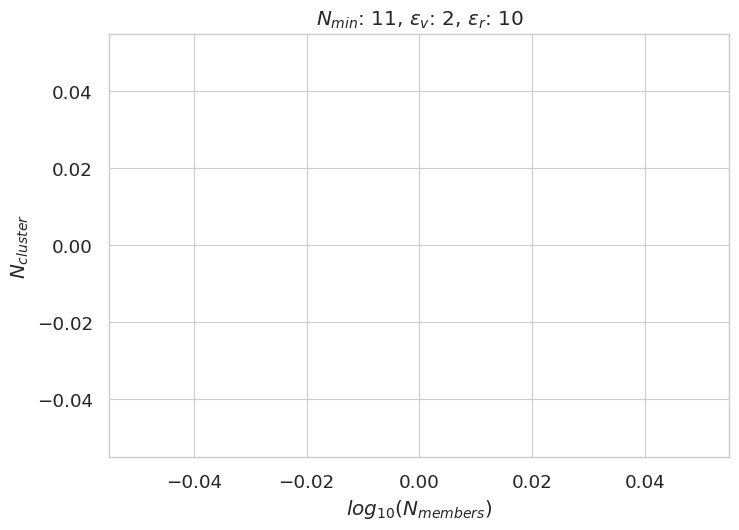

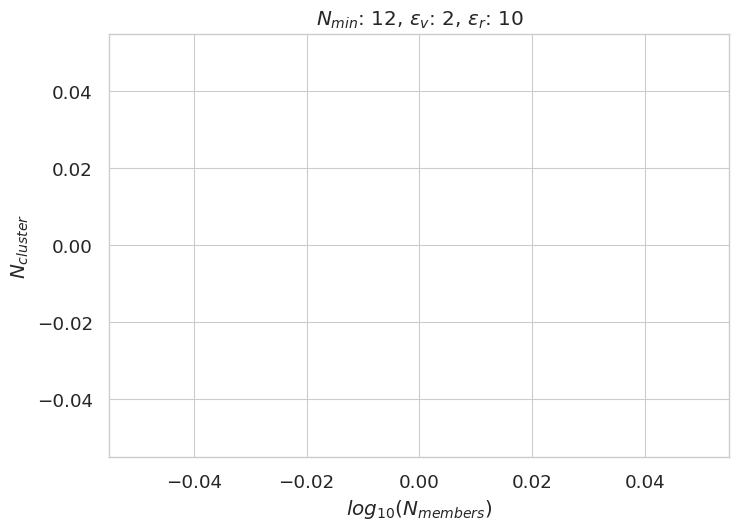

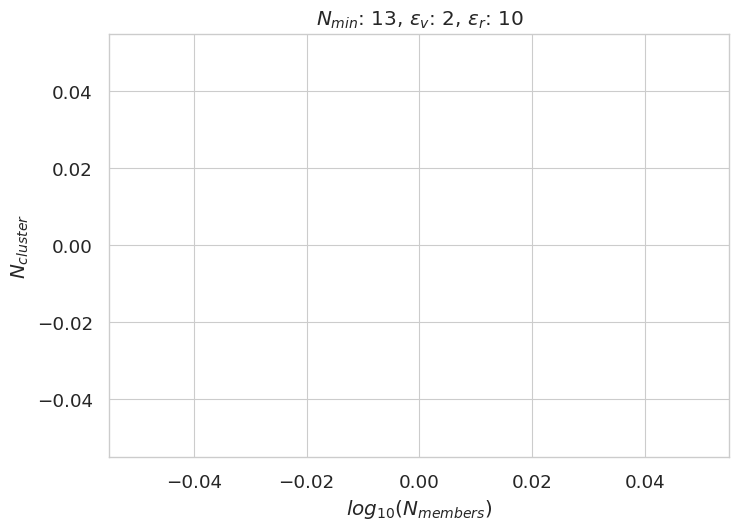

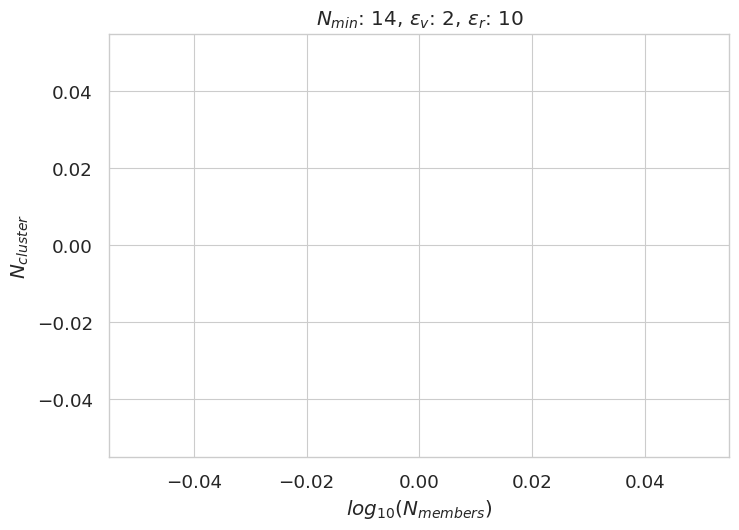

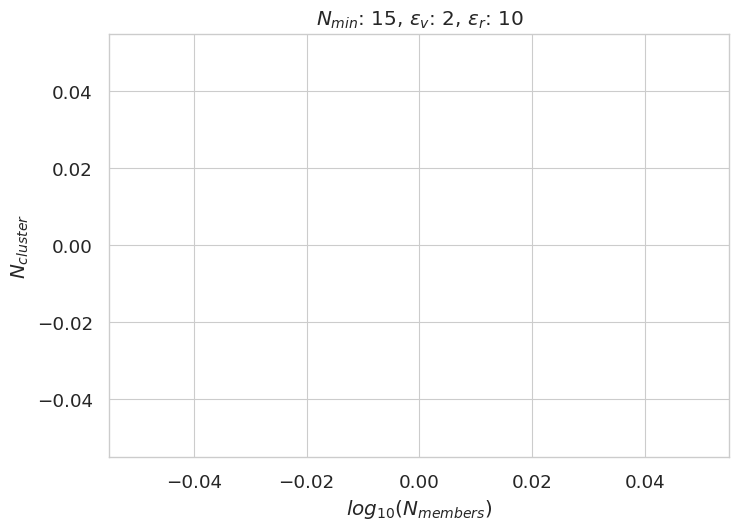

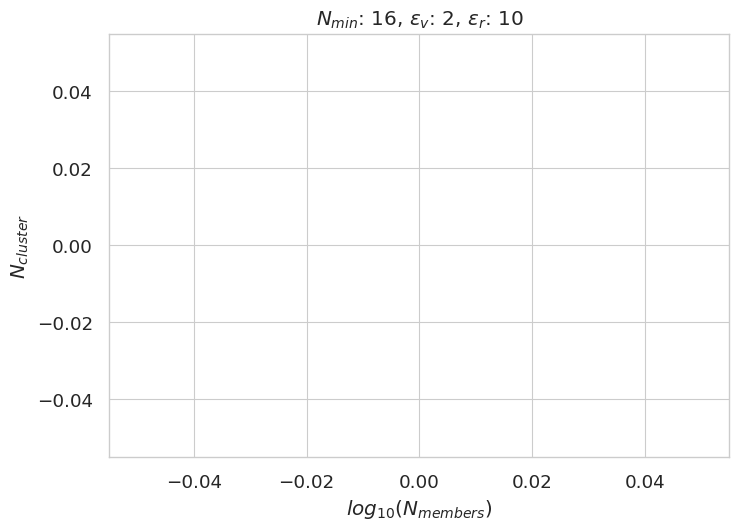

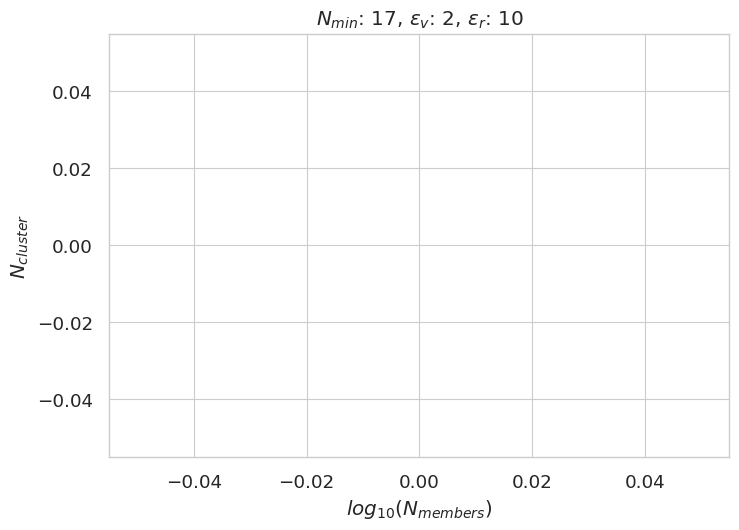

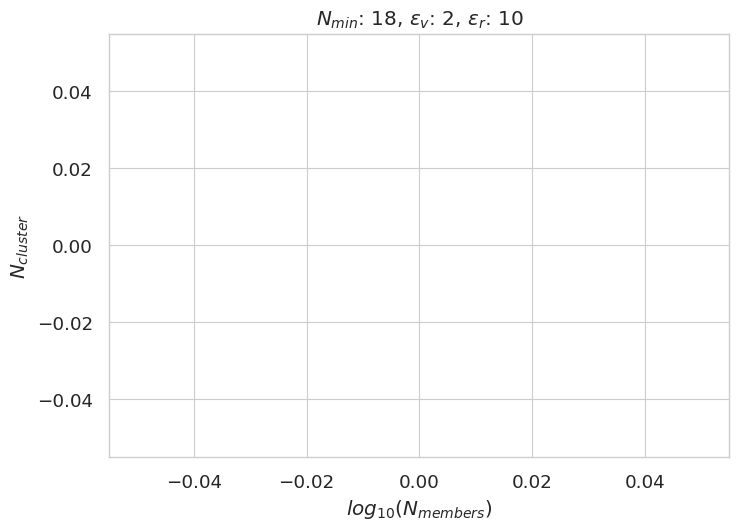

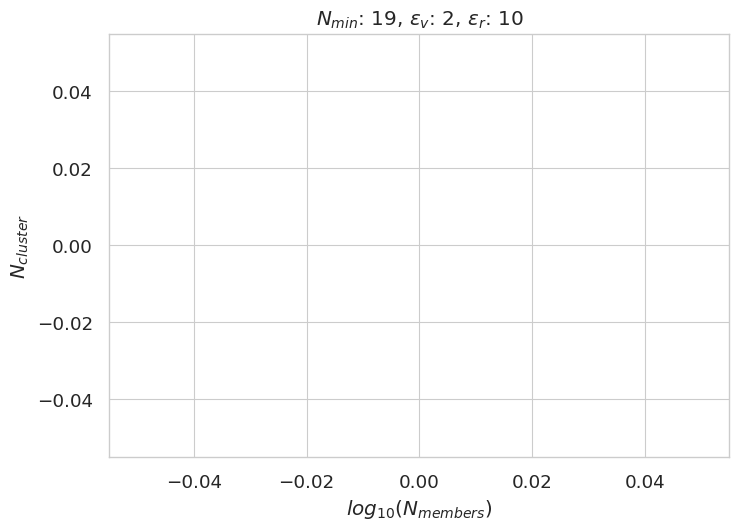

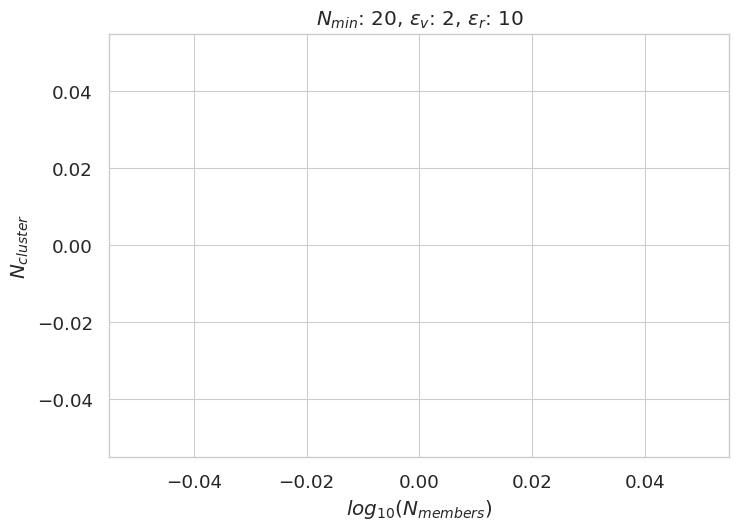

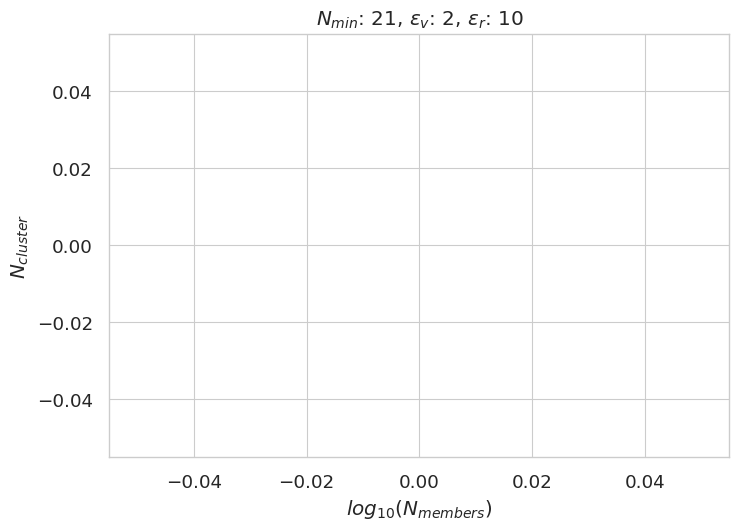

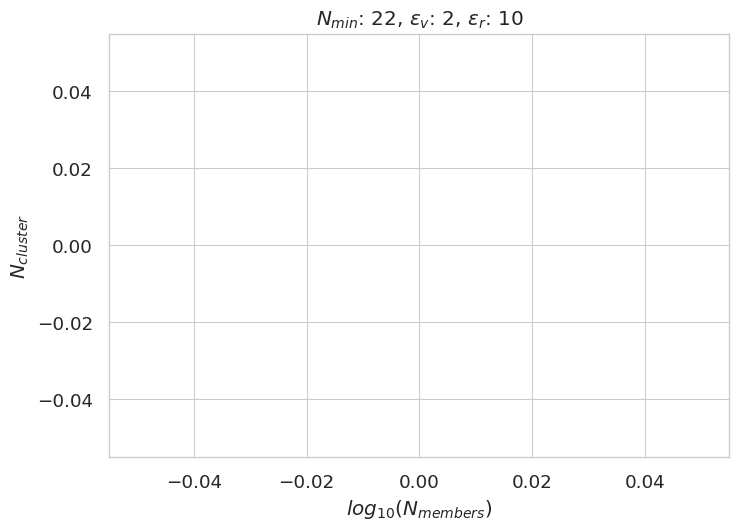

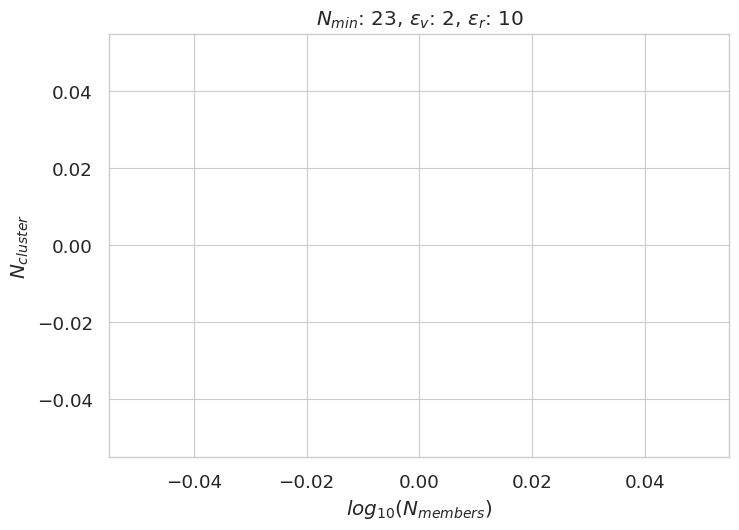

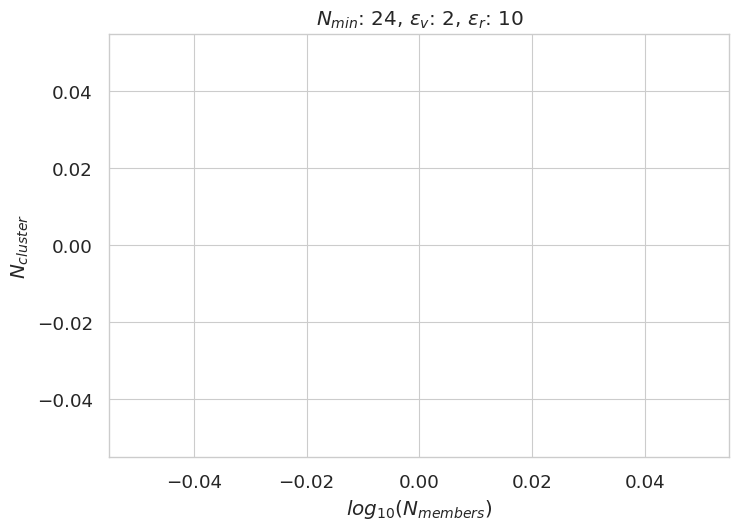

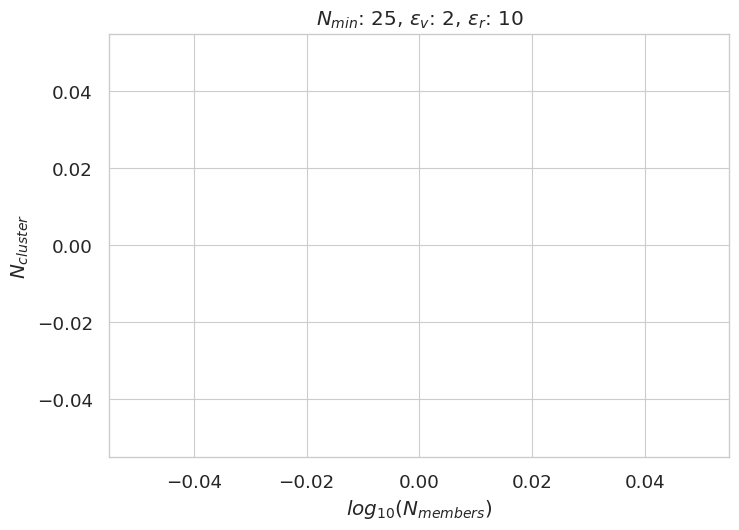

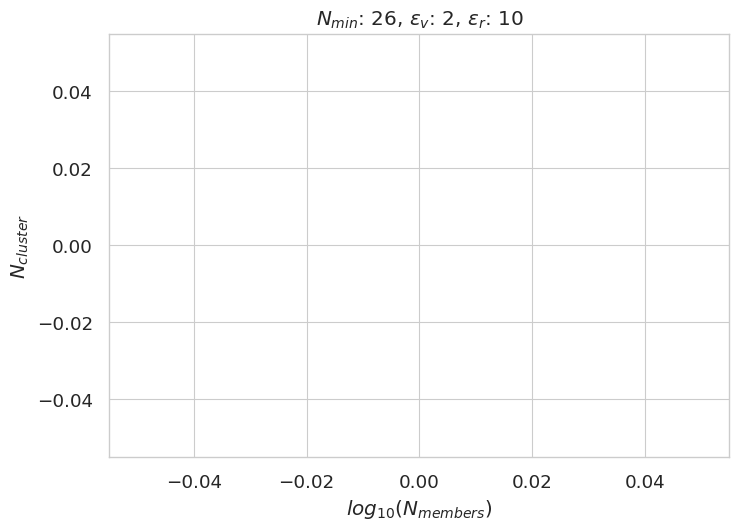

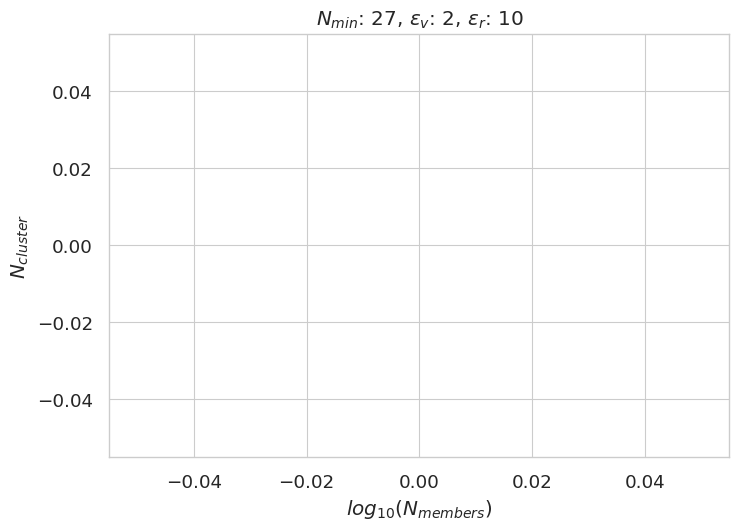

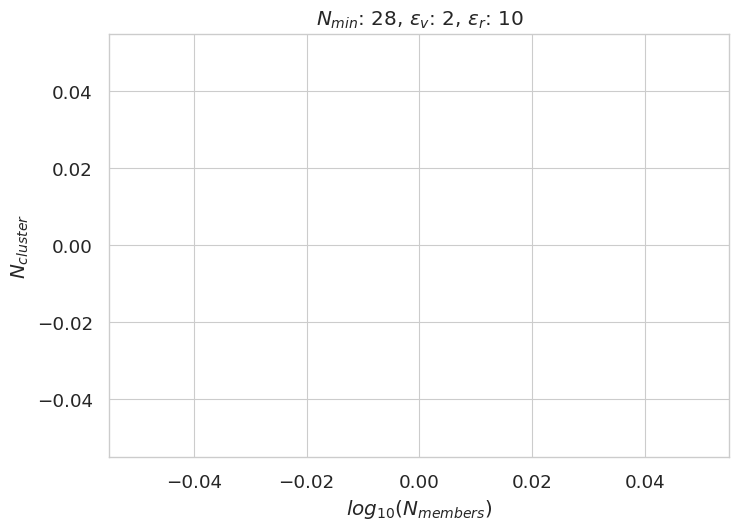

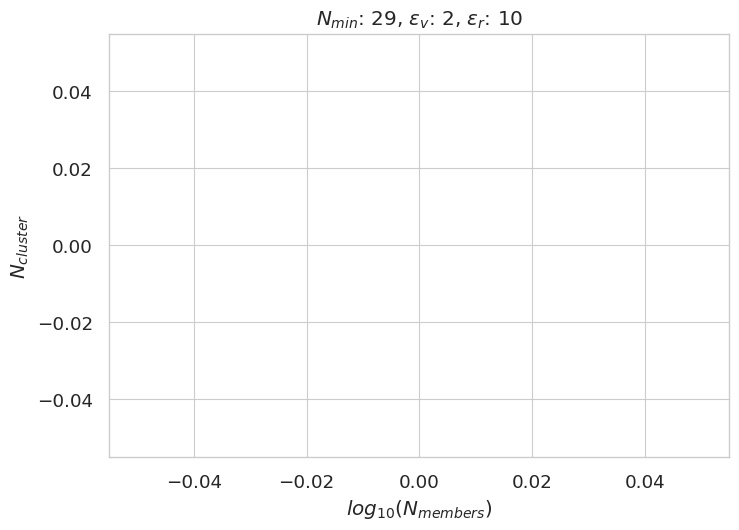

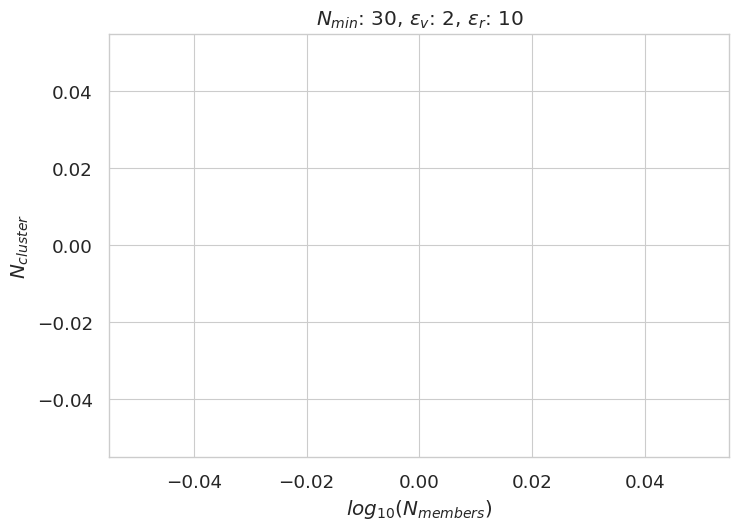

In [14]:
veps=2
reps=10
for nind in np.arange(0,len(deltaNmin),1):
    Nmin = deltaNmin[nind]
    nvClusterInfo = nvrClusterInfo[Nmin][list(filter(lambda v: round(v,2) == veps, deltaVeps))[0]][4]
    plt.scatter(np.log10(nvClusterInfo.nMembers),nvClusterInfo.nClusters)
    plt.plot(np.log10(nvClusterInfo.nMembers),nvClusterInfo.nClusters)
    plt.xlabel(r'$log_{10}(N_{members})$')
    plt.ylabel(r'$N_{cluster}$')
    plt.title(r'$N_{min}$: '+f'{Nmin}'+r', $\varepsilon_v$: '+f'{veps}'+r', $\varepsilon_r$: '+f'{reps}')
    plt.show()

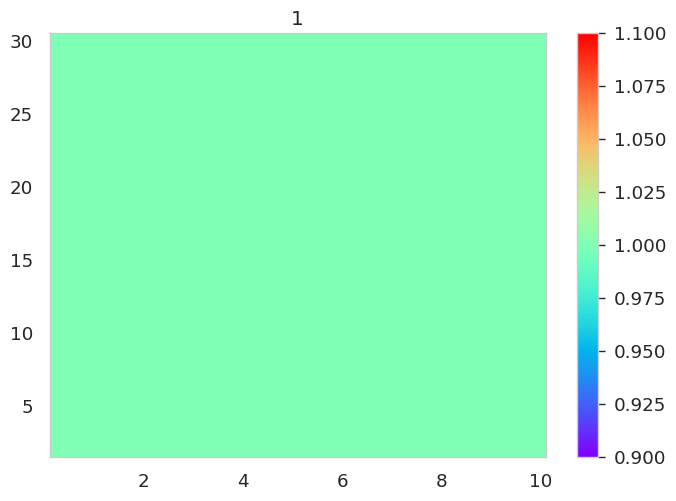

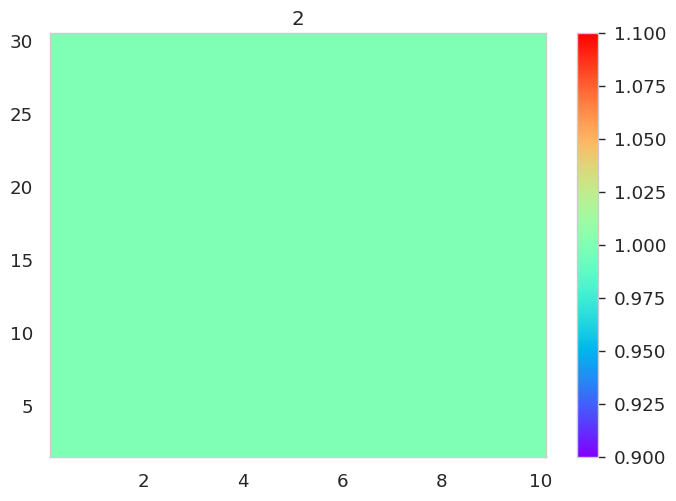

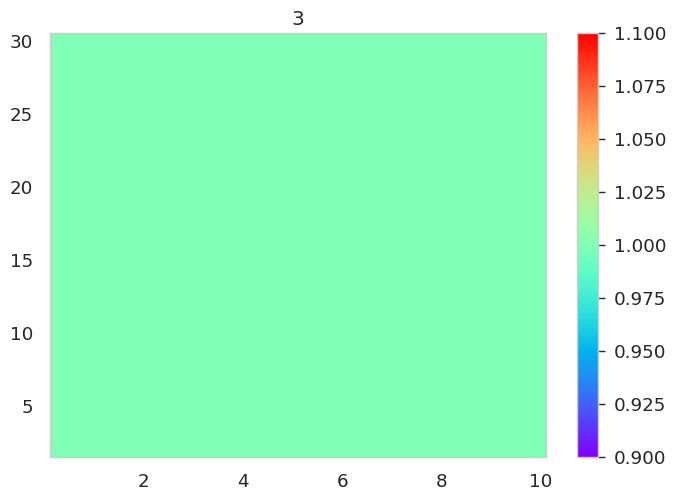

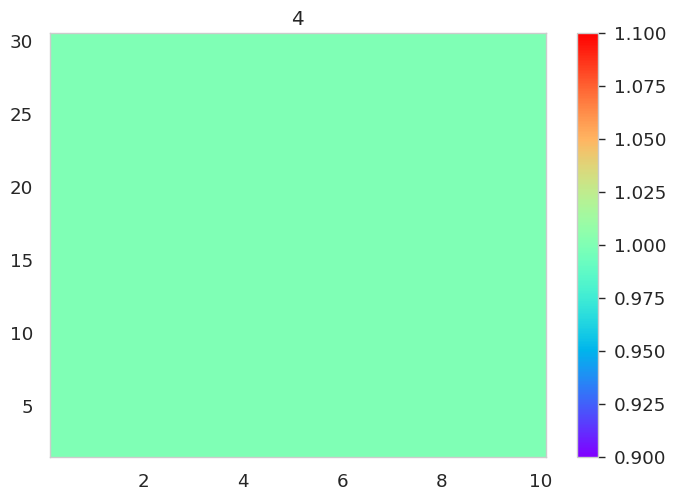

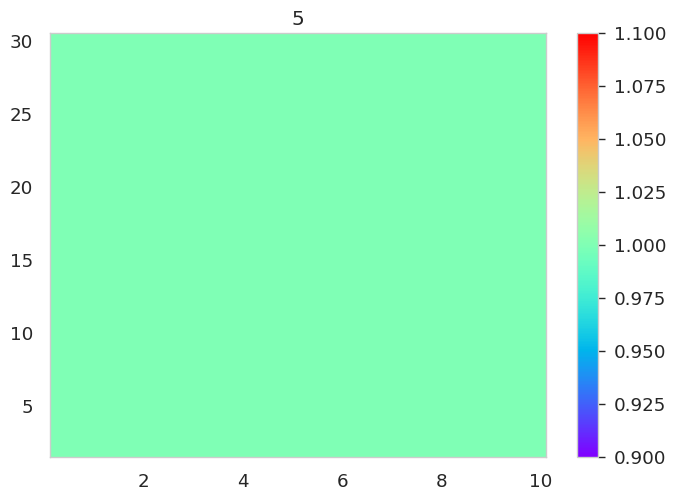

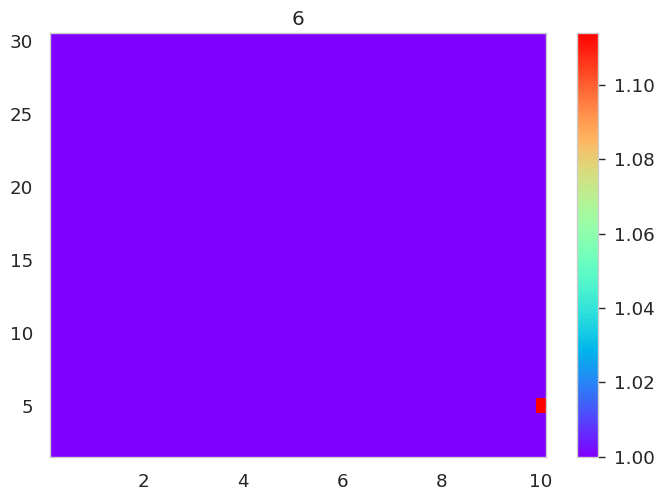

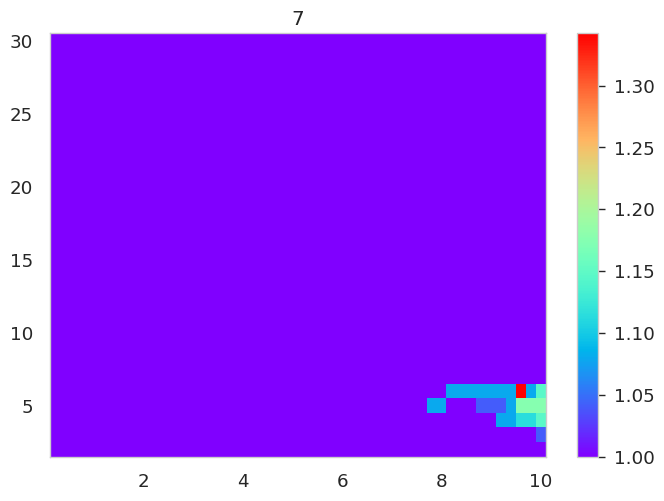

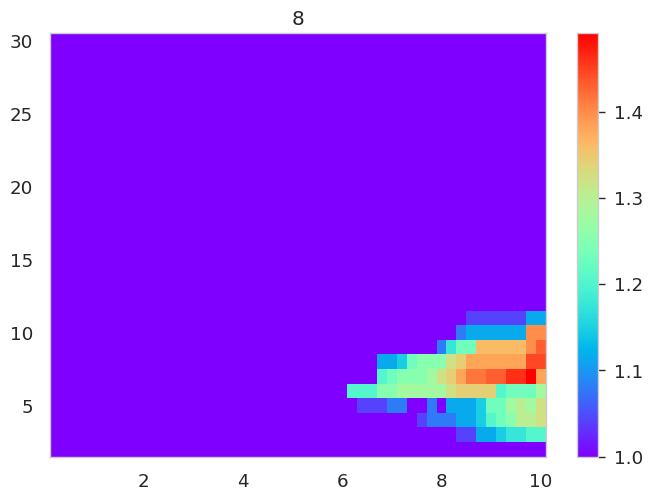

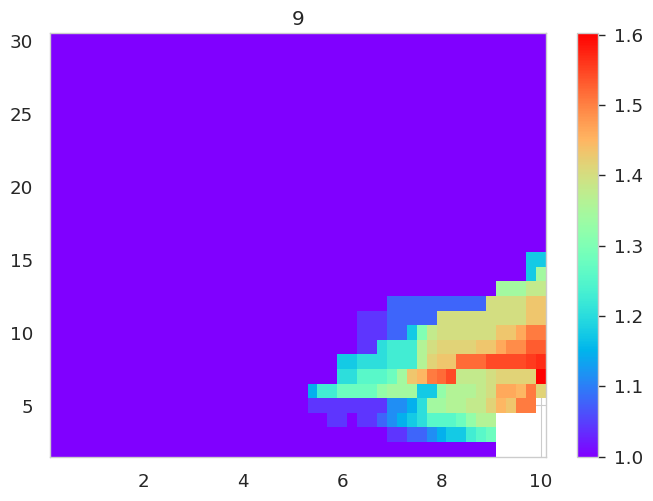

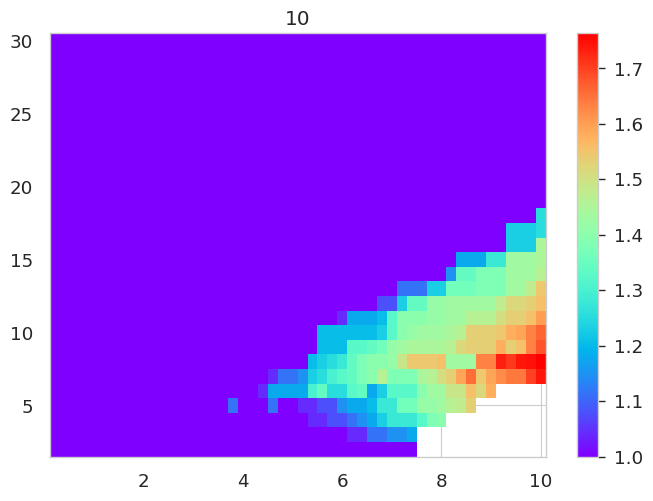

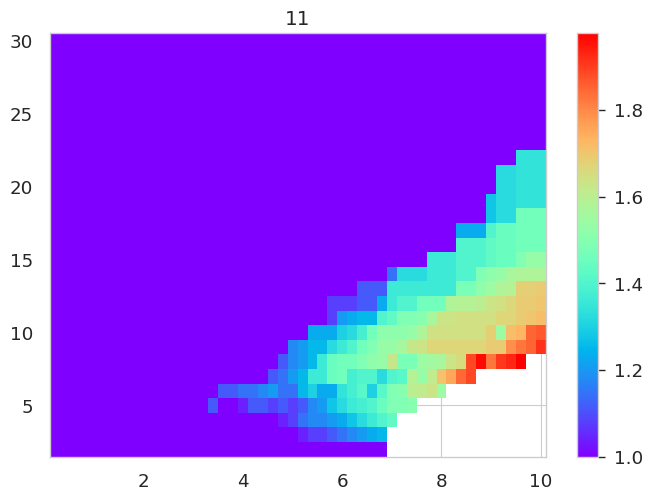

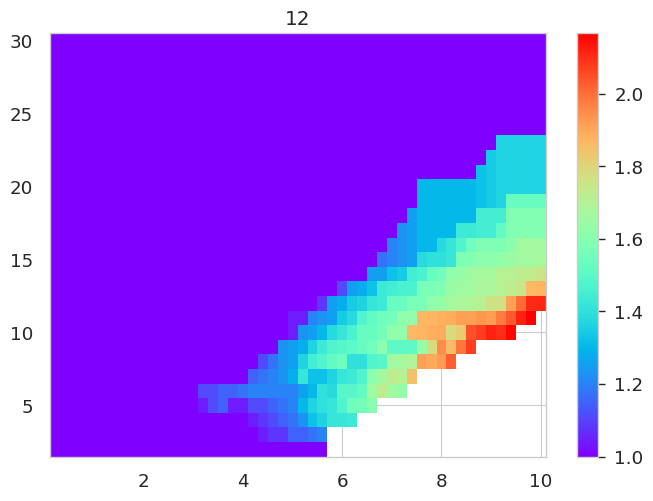

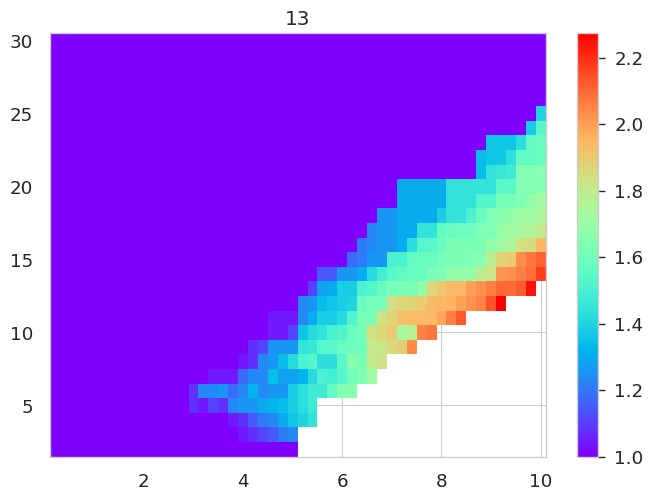

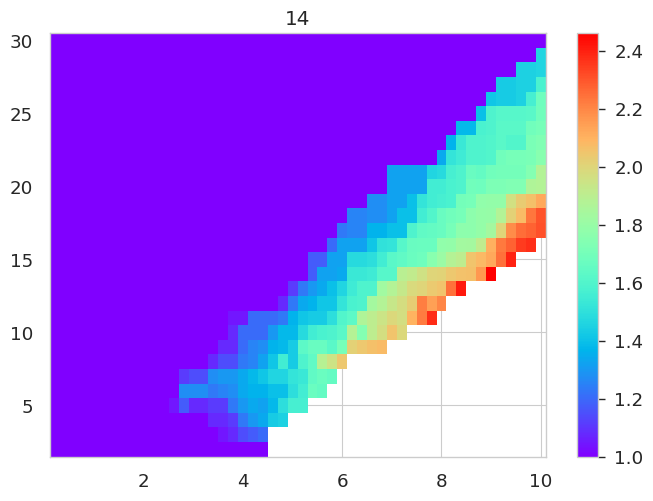

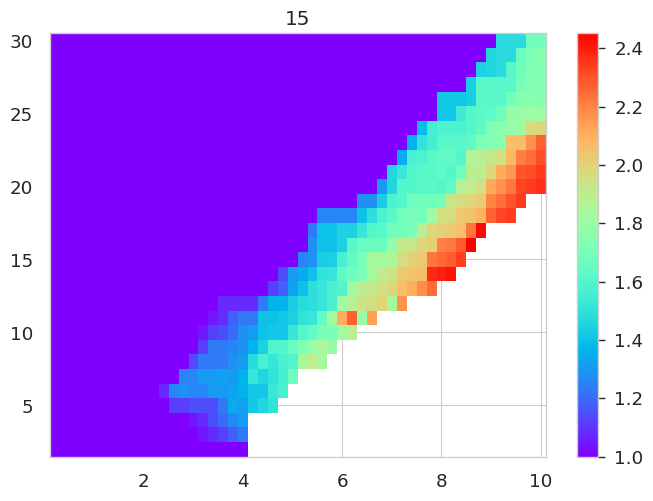

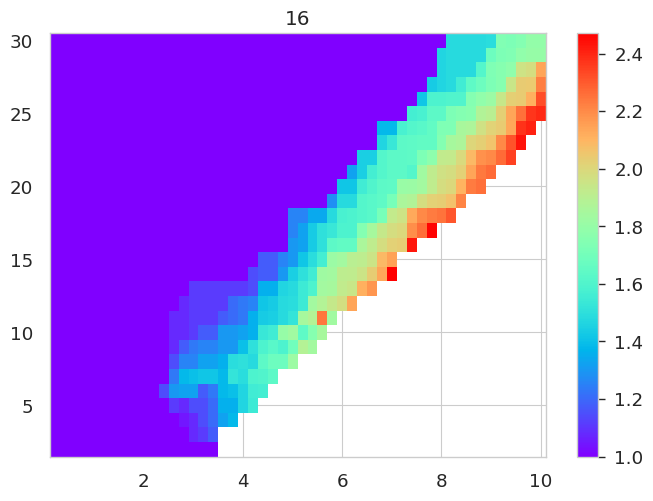

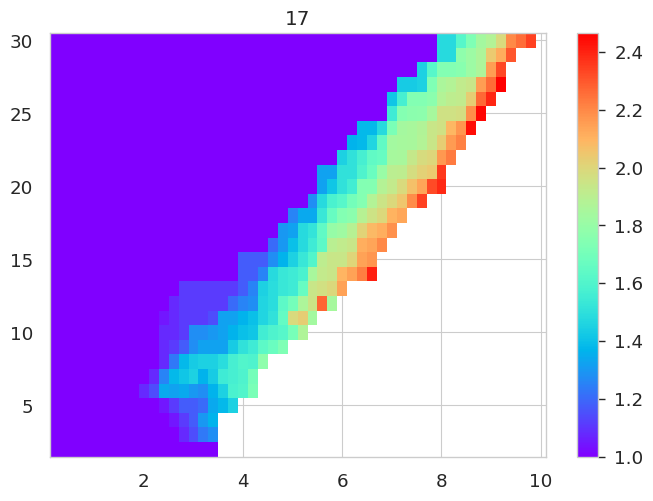

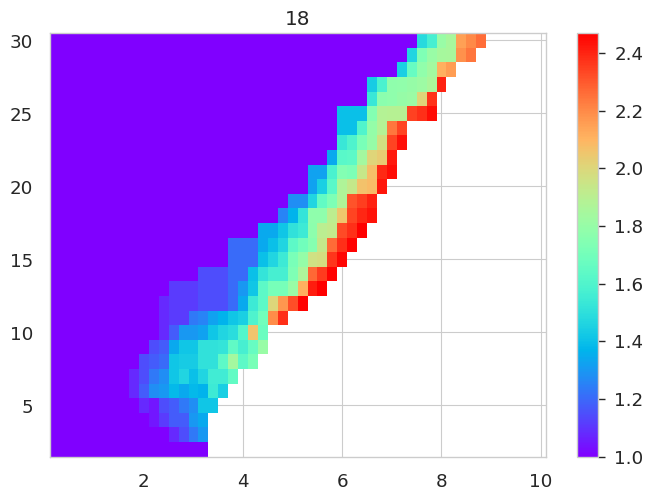

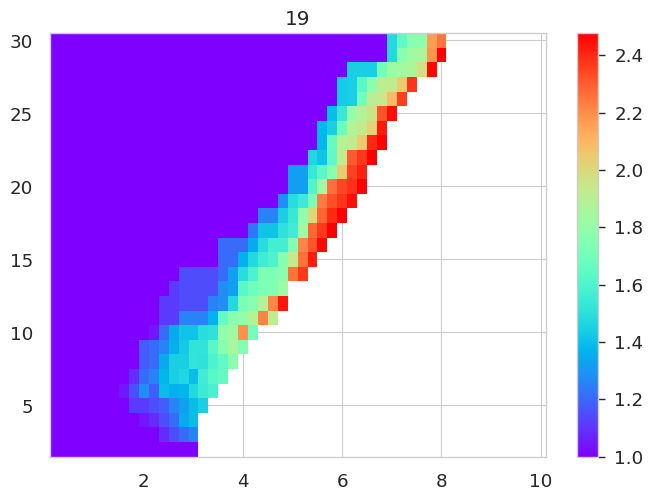

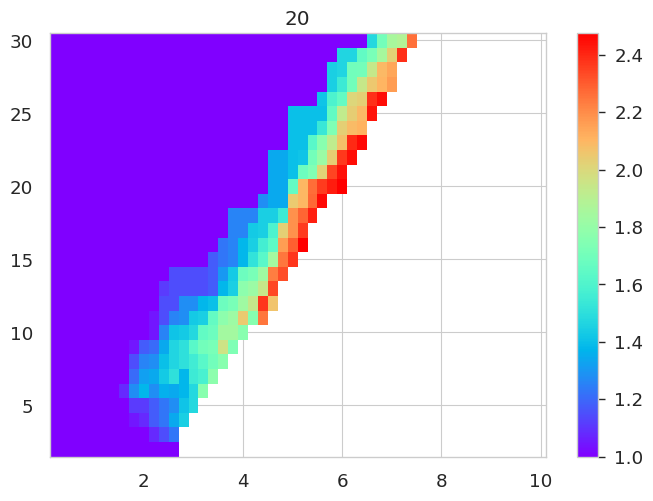

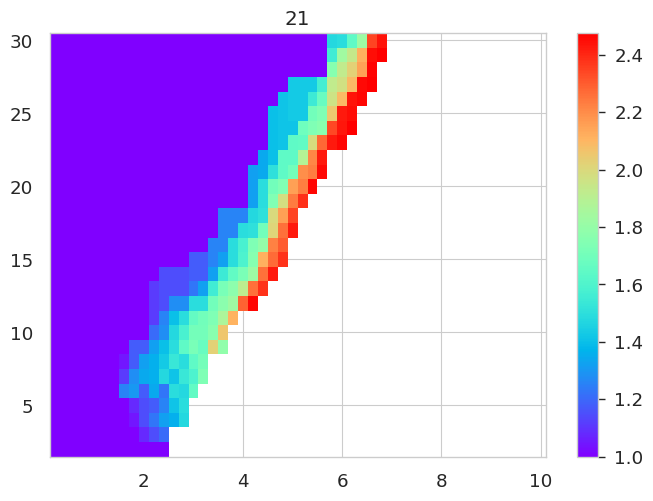

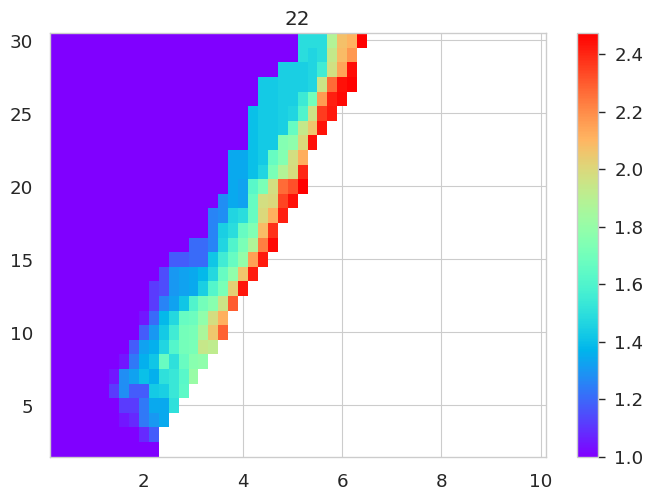

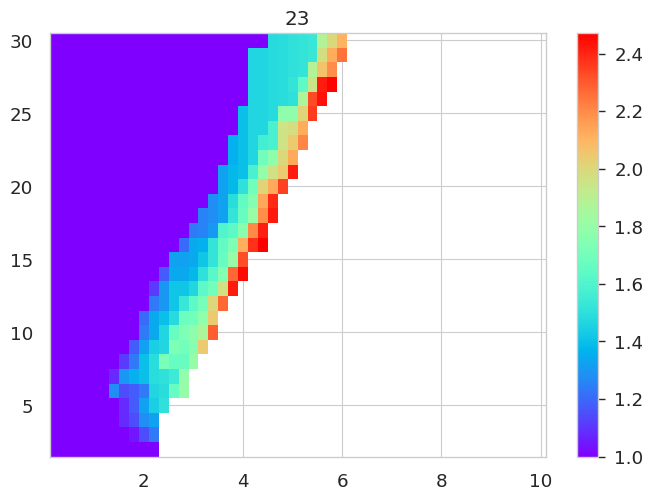

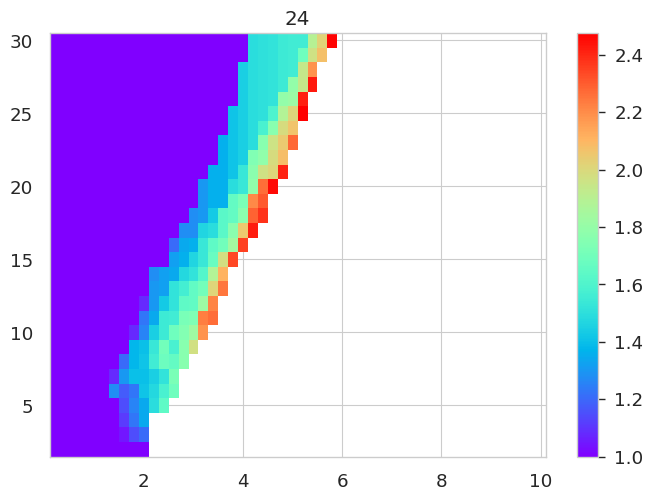

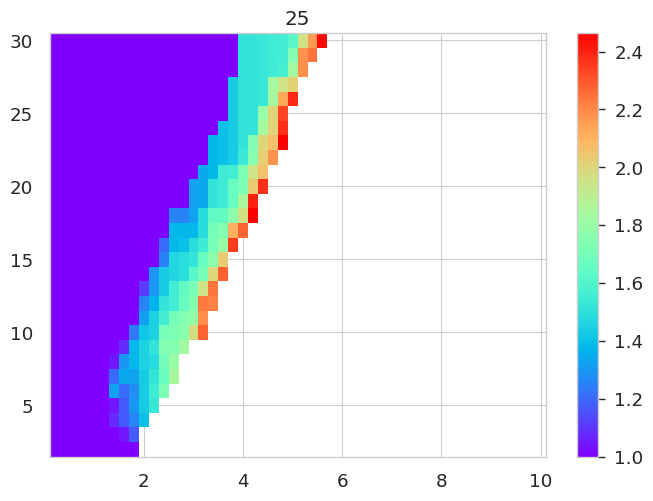

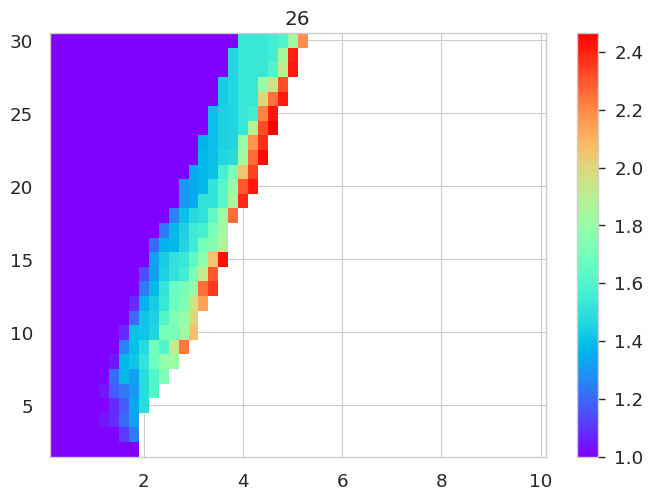

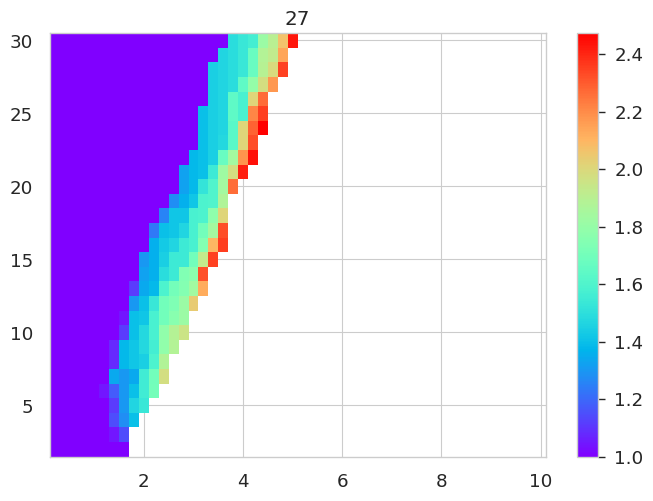

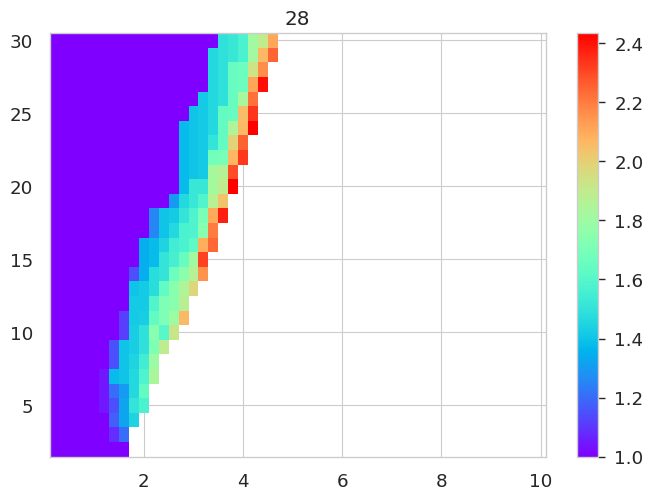

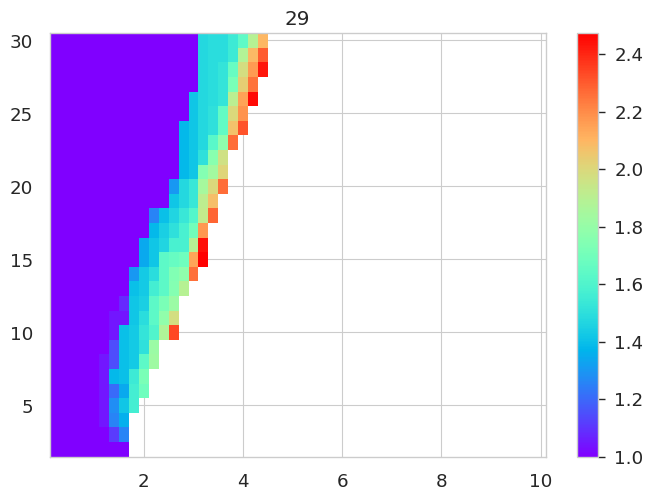

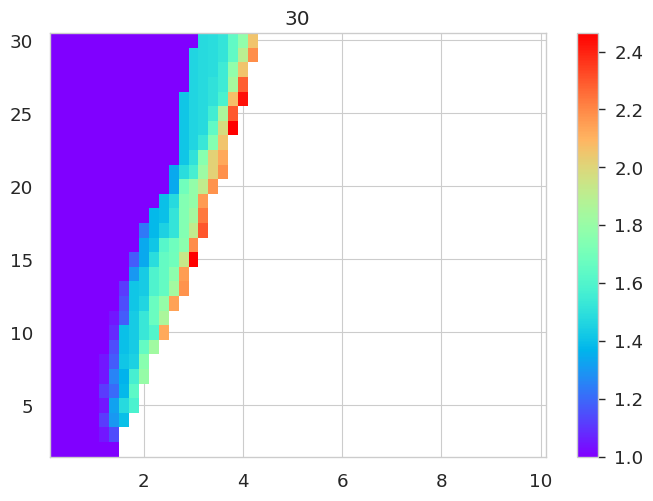

In [15]:
for rind in np.arange(0,len(deltaReps),1):
    reps = deltaReps[rind]
    nvmaps = NvNrMaps['nv'][reps]
    plt.pcolormesh(colmapVeps,colmapNminV,np.log10(nvmaps),cmap='rainbow');
    plt.title(reps);
    plt.colorbar();
    plt.show();